## **Data Processing**
### **Preparación de datos, exploración de datos, ingeniería de características, creación de modelo para BentoML**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
import os
from pathlib import Path

En este código hacemos un análisis exploratorio de la estructura de datos del dataset ONCE. Primero cargamos y examinamos un archivo JSON de una secuencia específica (000076), identificando las claves principales y la info de las cámaras. Luego, analizamos los frames de la secuencia para determinar como se organizan, verificando cuántos frames existen y las claves presentes en cada uno. Finalmente, determinamos qué tipos de datos están disponibles en los frames y con qué frecuencia aparecen, revelando que las anotaciones no están presentes en todos los frames sino aproximadamente cada dos frames.

In [4]:
# Leer un ejemplo de datso
with open("../../../ONCE/train/annotations/000076/000076.json", "r") as f:
    data = json.load(f)

# Coger las keys para ver el contenido que hay
top_keys = data.keys()
print("Top-level keys:", list(top_keys))
# Para ver que hay datos de cámaras:
calib_keys = data['calib'].keys()
print("Keys en 'calib', las cámaras:", list(calib_keys))



## Ahora mirar los frames, de donde vamos a sacar los datos
# Mirar los datos que hay para cada frame
if isinstance(data['frames'], dict):
    print("Keys under 'frames':", list(data['frames'].keys()))

# Mirar cuantas frames hay en esta secuencia que grabaron
elif isinstance(data['frames'], list):
    print("Number of items in 'frames':", len(data['frames']))
    if len(data['frames']) > 0:
        print("First item in 'frames':", data['frames'][0])

if isinstance(data['frames'], list) and len(data['frames']) > 0:
    first_item_keys = data['frames'][0].keys() if isinstance(data['frames'][0], dict) else None
    print("Keys of the first frame item:", first_item_keys)


# Mirar las anotaciones y cuantas veces aparecen en los datos de los frames (annotaciones menos veces como los frames son muy juntos, uno frame tiene anotaciones cada dos más o menos) 
if isinstance(data['frames'], list):
    key_counter = Counter()
    
    for frame in data['frames']:
        if isinstance(frame, dict):
            key_counter.update(frame.keys())
    
    # Print los counts
    for key, count in key_counter.items():
        print(f"Key '{key}' appears {count} times")


Top-level keys: ['meta_info', 'calib', 'frames']
Keys en 'calib', las cámaras: ['cam01', 'cam03', 'cam05', 'cam06', 'cam07', 'cam08', 'cam09']
Number of items in 'frames': 2055
First item in 'frames': {'sequence_id': '000076', 'frame_id': '1616343527200', 'annos': {'names': ['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Truck', 'Cyclist', 'Cyclist', 'Cyclist', 'Cyclist', 'Cyclist', 'Cyclist', 'Cyclist', 'Pedestrian'], 'boxes_3d': [[-3.460779890336198, 11.889099506707907, -0.8206982783150591, 4.555971205891034, 1.8030093908309937, 1.5509192471702893, 5.2348885297696235], [-0.9969175029538491, -38.69317913045427, -1.2679895304161408, 4.708746910095215, 1.7456061840057373, 1.5380195379257202, 0.14170256455475894], [-11.875659942626953, -28.584253311157227, -1.1764512062072754, 4.154930114746094, 1.8246525526046753, 1.4076584577560425, 3.9471536000543317], [26.029391688726562, 9.458823658682036, -0.8783

Hemos seguido analizando los frames de la secuencia 000076. Primero calculamos el número total de frames disponibles, luego identificamos todos los campos de datos posibles examinando cada frame. Después, determinamos cuántos frames contienen cada tipo específico de dato y sus porcentajes correspondientes. Finalmente, examinamos el contenido del primer frame como ejemplo concreto de la estructura de datos que tenemos en los .json. El json contiene información de los bounding boxes en 2D y 3D pero esos datos nos los vamos a utilizar en este análisis. Estos se utilizan en el resto de modelos, por ejemplo el de World Models.

In [5]:
with open("../../../ONCE/train/annotations/000076/000076.json", "r") as f:
    data = json.load(f)

# Primero visualizamos las keys
if 'frames' in data and isinstance(data['frames'], list):
    print(f"Número total de frames: {len(data['frames'])}")
    print("-" * 50)
    all_keys_set = set()
    
    for i, frame in enumerate(data['frames']):
        if isinstance(frame, dict):
            # Agregar todas las keys de este frame al conjunto
            all_keys_set.update(frame.keys())
    
    # Prints de todas las keys encontradas
    print("Todas las keys que aparecen en los frames:")
    for key in sorted(all_keys_set):
        print(f"  - '{key}'")
    
    print("-" * 50)
    
    # Print de cuantas veces aparecen los datos en los frames
    print("Presencia de cada key en los frames:")
    
    # Contar cuántos frames tienen cada key
    key_counts = {}
    total_frames = len(data['frames'])
    
    for key in all_keys_set:
        count = sum(1 for frame in data['frames'] if key in frame)
        key_counts[key] = count
    
    for key in sorted(key_counts.keys()):
        count = key_counts[key]
        percentage = (count / total_frames) * 100
        optional = "" if count == total_frames else ""
        print(f"  - '{key}': {count}/{total_frames} frames ({percentage:.1f}%){optional}")
    
    print("-" * 50)
    
    # Visulizar el primer frame como ejemplo
    if len(data['frames']) > 0 and isinstance(data['frames'][0], dict):
        first_frame = data['frames'][0]
        print("Ejemplo del primer frame:")
        for key, value in first_frame.items():
            print(f"  '{key}': {type(value).__name__} = {str(value)[:100]}...")
            
else:
    print("Error")

Número total de frames: 2055
--------------------------------------------------
Todas las keys que aparecen en los frames:
  - 'annos'
  - 'frame_id'
  - 'pose'
  - 'sequence_id'
--------------------------------------------------
Presencia de cada key en los frames:
  - 'annos': 1000/2055 frames (48.7%)
  - 'frame_id': 2055/2055 frames (100.0%)
  - 'pose': 2055/2055 frames (100.0%)
  - 'sequence_id': 2055/2055 frames (100.0%)
--------------------------------------------------
Ejemplo del primer frame:
  'sequence_id': str = 000076...
  'frame_id': str = 1616343527200...
  'annos': dict = {'names': ['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car'...
  'pose': list = [0.00024311428049490985, 0.00017701105971588282, -0.010381742739618569, 0.9999460630355117, -0.02217...


### **Limpieza de datos LiDAR**
Esta es una función para analizar y filtrar datos LiDAR. Esta función carga archivos binarios que contienen coordenadas 3D (x, y, z) e intensidad de cada punto, calcula la distancia horizontal de cada punto al vehículo, y elimina aquellos que superan un umbral máximo (por defecto 100 metros). Esto permite reducir el ruido y enfocarnos en los objetos cercanos más relevantes para conducción autónoma (este filttrado y limpieza se hará cuando creemos el dataset tabular).

También generamos estadísticas detalladas sobre los puntos antes y después del filtrado, incluyendo su distribución por rangos de distancia. Después visualizamos los resultados con gráficos comparativos: puntos originales vs filtrados, distribución de distancias, visualización 3D de puntos cercanos, y relación entre intensidad y distancia. Este análisis nos ayuda a preparar los datos LiDAR para aplicaciones posteriores. Todas las visualizaciones van a estar en nuestra aplicación de Streamlit también.

ANÁLISIS DE LIDAR: 1616343527200.bin
Número de puntos totales: 62,998
Número de puntos dentro de 100m: 60,361
Número de puntos eliminados (> 100m): 2,637
Porcentaje conservado: 95.8%
Tamaño del archivo: 1,007,968 bytes
Formato: 4 valores por punto
Columnas: ['x', 'y', 'z', 'intensity']

ESTADÍSTICAS DE PUNTOS DENTRO DE 100m:
Coordenada X: Min=-79.76, Max=99.44
Coordenada Y: Min=-99.98, Max=99.57
Coordenada Z: Min=-2.49, Max=23.04
  Intensidad: Min=0.00, Max=196.00, Media=0.46

ESTADÍSTICAS DE DISTANCIA (dentro de 100m):
Distancia mínima: 0.30m
Distancia máxima: 99.99m
Distancia media: 23.27m
Distancia mediana: 16.26m

DISTRIBUCIÓN POR RANGOS DE DISTANCIA:
  0-10m: 12,466 puntos (20.7%)
  10-20m: 26,391 puntos (43.7%)
  20-30m: 7,973 puntos (13.2%)
  30-40m: 4,380 puntos (7.3%)
  40-50m: 3,100 puntos (5.1%)
  50-60m: 1,442 puntos (2.4%)
  60-70m: 1,558 puntos (2.6%)
  70-80m: 936 puntos (1.6%)
  80-90m: 1,010 puntos (1.7%)
  90-100m: 1,105 puntos (1.8%)

EJEMPLO PUNTOS FILTRADOS:
  Punt

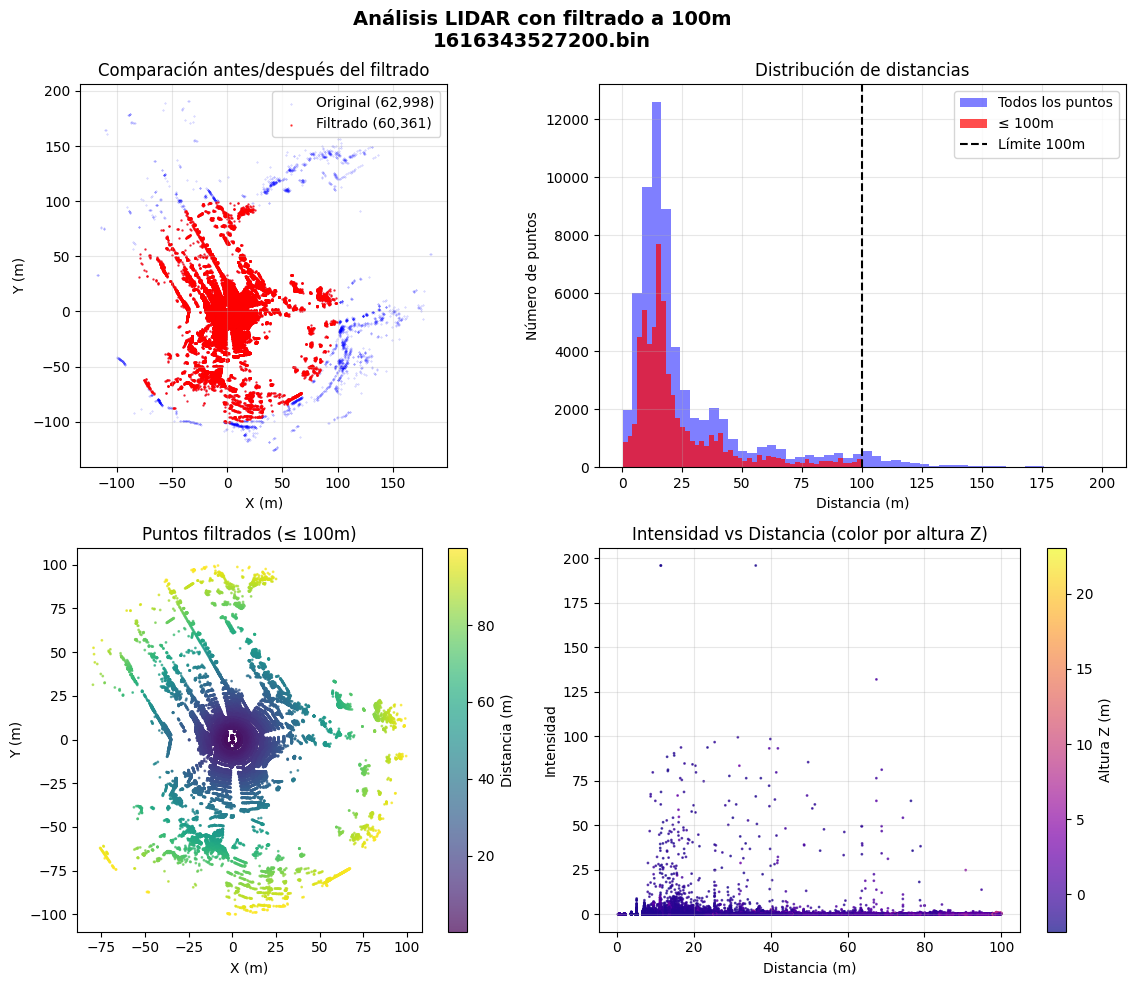

In [8]:
def analyze_lidar_bin_with_filter(file_path, bytes_per_point=16, max_distance=100):
    try:
        # Leer el archivo binario que tiene los dtos LiDAR
        with open(file_path, 'rb') as f:
            data = f.read()
        
        # Calcular número de puntos totales en el arhivo .bin
        file_size = len(data)
        n_points = file_size // bytes_per_point
        
        # Cargar los datos como array numpy
        if n_points > 0:
            points = np.frombuffer(data[:n_points * bytes_per_point], dtype=np.float32)
            
            # Reshape al formato de LiDAR
            if bytes_per_point == 16:  # 4 floats
                points = points.reshape(-1, 4)
                columns = ['x', 'y', 'z', 'intensity']
            else:
                print(f"Formato no soportado: {bytes_per_point} bytes por punto")
                return None
            
            # Calcular distancia horizontal (x, y) - ignorando z (la altura) para la distancia
            distances = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
            
            # Filtrar puntos dentro del rango de distancia
            mask = distances <= max_distance
            points_filtered = points[mask]
            distances_filtered = distances[mask]
            
            # Estadísticas antes del filtrado (este filtrado se va a hacer cuando guardemos todos los datos)
            print(f"ANÁLISIS DE LIDAR: {os.path.basename(file_path)}")
            print("="*50)
            print(f"Número de puntos totales: {n_points:,}")
            print(f"Número de puntos dentro de {max_distance}m: {len(points_filtered):,}")
            print(f"Número de puntos eliminados (> {max_distance}m): {n_points - len(points_filtered):,}")
            print(f"Porcentaje conservado: {len(points_filtered)/n_points*100:.1f}%")
            print(f"Tamaño del archivo: {file_size:,} bytes")
            print(f"Formato: {len(columns)} valores por punto")
            print(f"Columnas: {columns}")
            
            # Estadísticas de los puntos FILTRADOS
            if len(points_filtered) > 0:
                print(f"\nESTADÍSTICAS DE PUNTOS DENTRO DE {max_distance}m:")
                print(f"Coordenada X: Min={points_filtered[:, 0].min():.2f}, Max={points_filtered[:, 0].max():.2f}")
                print(f"Coordenada Y: Min={points_filtered[:, 1].min():.2f}, Max={points_filtered[:, 1].max():.2f}")
                print(f"Coordenada Z: Min={points_filtered[:, 2].min():.2f}, Max={points_filtered[:, 2].max():.2f}")
                
                if 'intensity' in columns:
                    intensity_idx = columns.index('intensity')
                    print(f"  Intensidad: Min={points_filtered[:, intensity_idx].min():.2f}, "
                          f"Max={points_filtered[:, intensity_idx].max():.2f}, "
                          f"Media={points_filtered[:, intensity_idx].mean():.2f}")
                
                # Estadísticas de distancia de los puntos filtrados
                print(f"\nESTADÍSTICAS DE DISTANCIA (dentro de {max_distance}m):")
                print(f"Distancia mínima: {distances_filtered.min():.2f}m")
                print(f"Distancia máxima: {distances_filtered.max():.2f}m")
                print(f"Distancia media: {distances_filtered.mean():.2f}m")
                print(f"Distancia mediana: {np.median(distances_filtered):.2f}m")
                
                # Distribución por rangos de distancia
                print(f"\nDISTRIBUCIÓN POR RANGOS DE DISTANCIA:")
                bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                labels = ['0-10', '10-20', '20-30', '30-40', '40-50', 
                         '50-60', '60-70', '70-80', '80-90', '90-100']
                
                hist, bin_edges = np.histogram(distances_filtered, bins=bins)
                for i, (label, count) in enumerate(zip(labels, hist)):
                    if count > 0:
                        percentage = count / len(distances_filtered) * 100
                        print(f"  {label}m: {count:,} puntos ({percentage:.1f}%)")
                
                # Poner ejemplos
                print(f"\nEJEMPLO PUNTOS FILTRADOS:")
                for i in range(min(5, len(points_filtered))):
                    print(f"  Punto {i}: X={points_filtered[i, 0]:.2f}, Y={points_filtered[i, 1]:.2f}, "
                          f"Z={points_filtered[i, 2]:.2f}, Dist={distances_filtered[i]:.2f}m")
            else:
                print(f"\nNo hay puntos dentro de {max_distance}m")
            
            return {
                'file_path': file_path,
                'n_points_total': n_points,
                'n_points_filtered': len(points_filtered),
                'max_distance': max_distance,
                'file_size_bytes': file_size,
                'points_original': points,
                'points_filtered': points_filtered,
                'distances_filtered': distances_filtered,
                'columns': columns,
                'mask': mask 
            }
        else:
            print(f"Archivo vacío: {file_path}")
            return None
            
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

# Ejemplo con archivo .bin
lidar_file = "../../../ONCE/train/lidar/000076/lidar_roof/1616343527200.bin"

if os.path.exists(lidar_file):
    result = analyze_lidar_bin_with_filter(lidar_file, bytes_per_point=16, max_distance=100)
    
    if result:
        # Visualizar la comparación
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Comparación de puntos antes/después
        ax1 = axes[0, 0]
        ax1.scatter(result['points_original'][:, 0], result['points_original'][:, 1], 
                   s=0.1, alpha=0.3, label=f"Original ({result['n_points_total']:,})", color='blue')
        ax1.scatter(result['points_filtered'][:, 0], result['points_filtered'][:, 1], 
                   s=0.5, alpha=0.7, label=f"Filtrado ({result['n_points_filtered']:,})", color='red')
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_title('Comparación antes/después del filtrado')
        ax1.legend()
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)
        
        # Distribución de distancias
        ax2 = axes[0, 1]
        distances_all = np.sqrt(result['points_original'][:, 0]**2 + result['points_original'][:, 1]**2)
        ax2.hist(distances_all, bins=50, alpha=0.5, label='Todos los puntos', color='blue')
        ax2.hist(result['distances_filtered'], bins=50, alpha=0.7, label=f'≤ {result["max_distance"]}m', color='red')
        ax2.axvline(x=result['max_distance'], color='black', linestyle='--', label=f'Límite {result["max_distance"]}m')
        ax2.set_xlabel('Distancia (m)')
        ax2.set_ylabel('Número de puntos')
        ax2.set_title('Distribución de distancias')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3D de puntos filtrados
        ax3 = axes[1, 0]
        scatter = ax3.scatter(result['points_filtered'][:, 0], result['points_filtered'][:, 1], 
                             c=result['distances_filtered'], cmap='viridis', s=1, alpha=0.7)
        ax3.set_xlabel('X (m)')
        ax3.set_ylabel('Y (m)')
        ax3.set_title(f'Puntos filtrados (≤ {result["max_distance"]}m)')
        ax3.set_aspect('equal')
        plt.colorbar(scatter, ax=ax3, label='Distancia (m)')
        
        # Plot de Intensidad vs Distancia
        ax4 = axes[1, 1]
        if 'intensity' in result['columns']:
            intensity_idx = result['columns'].index('intensity')
            scatter2 = ax4.scatter(result['distances_filtered'], 
                                  result['points_filtered'][:, intensity_idx],
                                  c=result['points_filtered'][:, 2],  # Color por altura Z
                                  cmap='plasma', s=1, alpha=0.7)
            ax4.set_xlabel('Distancia (m)')
            ax4.set_ylabel('Intensidad')
            ax4.set_title('Intensidad vs Distancia (color por altura Z)')
            plt.colorbar(scatter2, ax=ax4, label='Altura Z (m)')
            ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f'Análisis LIDAR con filtrado a {result["max_distance"]}m\n{os.path.basename(lidar_file)}', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
else:
    print(f"Archivo no encontrado: {lidar_file}")

Hemos creado una función que visualiza datos LiDAR organizándolos por rangos de distancia. Primero calculamos la distancia horizontal de cada punto y los clasificamos en rangos específicos (0-20m, 20-40m, etc...), asignando un color diferente a cada rango. Luego generamos cuatro visualizaciones: una vista 3D que muestra la distribución espacial completa, una vista superior que facilita la interpretación en 2D, un gráfico de barras con la cantidad exacta de puntos por rango, y un gráfico circular con los porcentajes correspondientes. Al igual que antes, estas visualizaciones estrán disponibles en Streamlit.

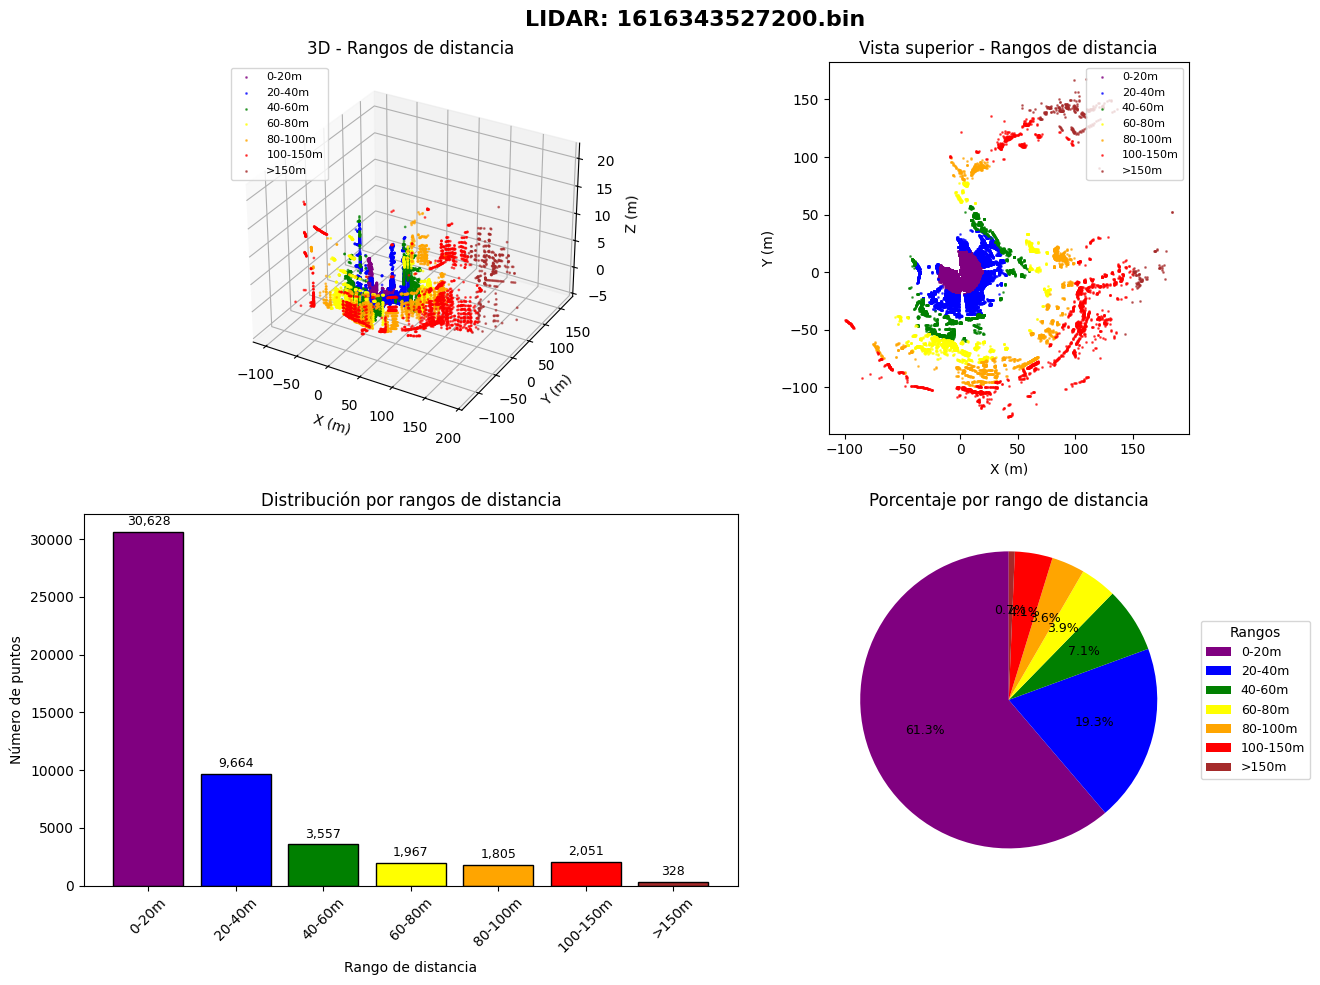


📊 ESTADÍSTICAS POR RANGO DE DISTANCIA:
purple 0-20m: 30,628 puntos (61.3%)
blue 20-40m: 9,664 puntos (19.3%)
green 40-60m: 3,557 puntos (7.1%)
yellow 60-80m: 1,967 puntos (3.9%)
orange 80-100m: 1,805 puntos (3.6%)
red 100-150m: 2,051 puntos (4.1%)
brown >150m: 328 puntos (0.7%)


In [ ]:
# Función para visualizar datos LiDAR por distancia y hacer comparativas
def visualize_lidar_distance_ranges(points, title="LIDAR - Rangos de distancia", max_points=50000):
    if len(points) > max_points:
        points = points[:max_points]
    
    # Calcular distancia
    distances = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
    
    # Definir rangos de distancia y colores
    distance_ranges = [0, 20, 40, 60, 80, 100, 150, float('inf')]
    colors = ['purple', 'blue', 'green', 'yellow', 'orange', 'red', 'brown']
    labels = ['0-20m', '20-40m', '40-60m', '60-80m', '80-100m', '100-150m', '>150m']
    
    # Asignar color por rango
    point_colors = []
    for d in distances:
        for i, (low, high) in enumerate(zip(distance_ranges[:-1], distance_ranges[1:])):
            if low <= d < high:
                point_colors.append(colors[i])
                break
    
    fig = plt.figure(figsize=(14, 10))
    
    # Plot 3D
    ax1 = fig.add_subplot(221, projection='3d')
    for i, color in enumerate(colors):
        mask = np.array(point_colors) == color
        if mask.any():
            ax1.scatter(points[mask, 0], points[mask, 1], points[mask, 2], 
                       color=color, s=1, alpha=0.6, label=labels[i])
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('3D - Rangos de distancia')
    ax1.legend(loc='upper left', fontsize=8)
    
    # Plot con vista superior
    ax2 = fig.add_subplot(222)
    for i, color in enumerate(colors):
        mask = np.array(point_colors) == color
        if mask.any():
            ax2.scatter(points[mask, 0], points[mask, 1], 
                       color=color, s=1, alpha=0.6, label=labels[i])
    
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('Vista superior - Rangos de distancia')
    ax2.set_aspect('equal')
    ax2.legend(loc='upper right', fontsize=8)
    
    # Distribución por rangos
    ax3 = fig.add_subplot(223)
    counts = []
    for i, (low, high) in enumerate(zip(distance_ranges[:-1], distance_ranges[1:])):
        count = ((distances >= low) & (distances < high)).sum()
        counts.append(count)
    
    bars = ax3.bar(labels, counts, color=colors, edgecolor='black')
    ax3.set_xlabel('Rango de distancia')
    ax3.set_ylabel('Número de puntos')
    ax3.set_title('Distribución por rangos de distancia')
    ax3.tick_params(axis='x', rotation=45)

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico circular que indica los mismo
    ax4 = fig.add_subplot(224)
    wedges, texts, autotexts = ax4.pie(counts, colors=colors, autopct='%1.1f%%',
                                       startangle=90, textprops={'fontsize': 9})
    ax4.set_title('Porcentaje por rango de distancia')
    ax4.legend(wedges, labels, title="Rangos", loc="center left", 
               bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Resumen de estadísticas
    print(f"\nESTADÍSTICAS POR RANGO DE DISTANCIA:")
    print("="*50)
    total_points = len(points)
    for i, (label, count, color) in enumerate(zip(labels, counts, colors)):
        percentage = (count / total_points) * 100
        print(f"{color} {label}: {count:,} puntos ({percentage:.1f}%)")
    
    return distances, point_colors

if result:
    distances, colors = visualize_lidar_distance_ranges(points, 
                                                        title=f"LIDAR: {os.path.basename(lidar_file)}")

### **Guardar todos los datos**
Hemos creado un CSV procesando cada frame de la secuencia con los siguientes datos: identificadores (`sequence_id`, `frame_id`) y flag de anotaciones (`has_annotations`) para trazabilidad; recuentos de vehículos por tipo (`count_Car`, `count_Truck`, `count_Bus`, etc.) como indicadores de densidad del tráfico; posición 3D (`pose_x`, `pose_y`, `pose_z`) y orientación con cuaterniones (`pose_qw`, `pose_qx`, `pose_qy`, `pose_qz`) del vehículo propio; y estadísticas LiDAR procesadas con un filtro de 100 metros para eliminar ruido y enfocarnos en objetos relevantes. Estas estadísticas incluyen: `lidar_n_points_total` (puntos totales escaneados), `lidar_n_points_under_100m` (puntos válidos cercanos), rangos espaciales (`lidar_x_min/max`, `lidar_y_min/max`, `lidar_z_min/max`), intensidad promedio (`lidar_intensity_mean`) como medida de reflectividad, y distribución detallada en franjas de 10 metros (`lidar_points_0_10m`, `lidar_points_10_20m`, ..., `lidar_points_90_100m`) para caracterizar la proximidad de objetos. La limpieza LiDAR consiste en descartar puntos más allá de 100m (considerados ruido o irrelevantes), calcular agregados estadísticos en lugar de guardar nubes de puntos completas. El objetivo es construir un dataset tabular para entrenar modelos de regresión que predigan la velocidad del vehículo (`speed_y`) basándose en el entorno inmediato.

In [ ]:
def analyze_lidar_file(lidar_path, max_distance=100):
    try:
        with open(lidar_path, 'rb') as f:
            data = f.read()
        
        # Formato ONCE: 4 floats (x, y, z, intensity)
        bytes_per_point = 16
        
        if len(data) % bytes_per_point != 0:
            n_points = len(data) // bytes_per_point
            data = data[:n_points * bytes_per_point]
        else:
            n_points = len(data) // bytes_per_point
        
        if n_points == 0: # por si hay errores
            return {
                'n_points_total': 0,
                'n_points_under_100m': 0,
                'x_min': np.nan, 'x_max': np.nan,
                'y_min': np.nan, 'y_max': np.nan,
                'z_min': np.nan, 'z_max': np.nan,
                'intensity_mean': np.nan,
                'points_0_10m': 0, 'points_10_20m': 0, 'points_20_30m': 0,
                'points_30_40m': 0, 'points_40_50m': 0, 'points_50_60m': 0,
                'points_60_70m': 0, 'points_70_80m': 0, 'points_80_90m': 0,
                'points_90_100m': 0
            }
        
        # Cargar puntos
        points = np.frombuffer(data, dtype=np.float32).reshape(-1, 4)
        
        # Calcular distancia horizontal (x, y)
        distances = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
        
        # Filtrar puntos dentro de 100m - hacemos esta limpiza con los LiDAR (en streamlit se puede elegir en las visualizaciones)
        mask_under_100m = distances <= max_distance
        points_under_100m = points[mask_under_100m]
        distances_under_100m = distances[mask_under_100m]
        
        # Calcular estadísticas básicas
        stats = {
            'n_points_total': n_points,
            'n_points_under_100m': len(points_under_100m),
            'x_min': points_under_100m[:, 0].min() if len(points_under_100m) > 0 else np.nan,
            'x_max': points_under_100m[:, 0].max() if len(points_under_100m) > 0 else np.nan,
            'y_min': points_under_100m[:, 1].min() if len(points_under_100m) > 0 else np.nan,
            'y_max': points_under_100m[:, 1].max() if len(points_under_100m) > 0 else np.nan,
            'z_min': points_under_100m[:, 2].min() if len(points_under_100m) > 0 else np.nan,
            'z_max': points_under_100m[:, 2].max() if len(points_under_100m) > 0 else np.nan,
            'intensity_mean': points_under_100m[:, 3].mean() if len(points_under_100m) > 0 else np.nan
        }
        
        # Contar puntos por rangos de distancia
        bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        
        if len(distances_under_100m) > 0:
            hist, _ = np.histogram(distances_under_100m, bins=bins)
            
            stats.update({
                'points_0_10m': hist[0],
                'points_10_20m': hist[1],
                'points_20_30m': hist[2],
                'points_30_40m': hist[3],
                'points_40_50m': hist[4],
                'points_50_60m': hist[5],
                'points_60_70m': hist[6],
                'points_70_80m': hist[7],
                'points_80_90m': hist[8],
                'points_90_100m': hist[9]
            })
        else:
            # Si no hay puntos, todos los rangos son 0
            stats.update({
                'points_0_10m': 0, 'points_10_20m': 0, 'points_20_30m': 0,
                'points_30_40m': 0, 'points_40_50m': 0, 'points_50_60m': 0,
                'points_60_70m': 0, 'points_70_80m': 0, 'points_80_90m': 0,
                'points_90_100m': 0
            })
        
        return stats
        
    except Exception as e:
        print(f"Error procesando {lidar_path}: {e}")
        return None

# Aquí se juntan todos los datos del .json y los .bin correspondientes a cada 
# Cargar datos JSON
json_path = "../../../ONCE/val/annotations/000201/000201.json"
with open(json_path, "r") as f:
    data = json.load(f)

# Identificar tipos de vehículos para contar vehículos por cada tipo
all_vehicle_types = set()
for frame in data.get('frames', []):
    if 'annos' in frame and 'names' in frame['annos']:
        all_vehicle_types.update(frame['annos']['names'])

all_vehicle_types = sorted(list(all_vehicle_types))
print(f"Tipos de vehículos encontrados: {all_vehicle_types}")

# Procesar cada frame
frames_data = []
sequence_id = data.get('frames', [{}])[0].get('sequence_id', '000201') if data.get('frames') else '000201'
lidar_base_path = f"../../../ONCE/val/lidar/{sequence_id}/lidar_roof/" # tienen en el nombre del fichero el mismo nombre

print(f"\nProcesando datos LIDAR desde: {lidar_base_path}")

frames_processed = 0
frames_with_lidar = 0
frames_missing_lidar = []

for frame in data.get('frames', []):
    frame_id = frame.get('frame_id', '')
    sequence_id = frame.get('sequence_id', '')
    
    # Inicializar diccionario para este frame
    frame_info = {
        'sequence_id': sequence_id,
        'frame_id': frame_id
    }
    
    # Contar vehículos (como antes)
    if 'annos' in frame and 'names' in frame['annos']:
        vehicle_counts = Counter(frame['annos']['names'])
        for vehicle_type in all_vehicle_types:
            frame_info[f'count_{vehicle_type}'] = 0
        for vehicle_type, count in vehicle_counts.items():
            frame_info[f'count_{vehicle_type}'] = count
    else:
        for vehicle_type in all_vehicle_types:
            frame_info[f'count_{vehicle_type}'] = 0
    
    # Añadir valores de pose 
    if 'pose' in frame and len(frame['pose']) >= 7:
        pose = frame['pose']
        frame_info['pose_qx'] = pose[0]
        frame_info['pose_qy'] = pose[1]
        frame_info['pose_qz'] = pose[2]
        frame_info['pose_qw'] = pose[3]
        frame_info['pose_x'] = pose[4]
        frame_info['pose_y'] = pose[5]
        frame_info['pose_z'] = pose[6]
    else:
        for col in ['pose_x', 'pose_y', 'pose_z', 'pose_qw', 'pose_qx', 'pose_qy', 'pose_qz']:
            frame_info[col] = np.nan
    
    # Indicar si tiene anotaciones (0 o 1)
    frame_info['has_annotations'] = 'annos' in frame
    
    # Procesar archivos LiDAR
    lidar_file = os.path.join(lidar_base_path, f"{frame_id}.bin")
    
    if os.path.exists(lidar_file):
        lidar_stats = analyze_lidar_file(lidar_file, max_distance=100)
        
        if lidar_stats:
            # Añadir estadísticas LIDAR al frame
            frame_info.update({
                'lidar_n_points_total': lidar_stats['n_points_total'],
                'lidar_n_points_under_100m': lidar_stats['n_points_under_100m'],
                'lidar_x_min': lidar_stats['x_min'],
                'lidar_x_max': lidar_stats['x_max'],
                'lidar_y_min': lidar_stats['y_min'],
                'lidar_y_max': lidar_stats['y_max'],
                'lidar_z_min': lidar_stats['z_min'],
                'lidar_z_max': lidar_stats['z_max'],
                'lidar_intensity_mean': lidar_stats['intensity_mean'],
                'lidar_points_0_10m': lidar_stats['points_0_10m'],
                'lidar_points_10_20m': lidar_stats['points_10_20m'],
                'lidar_points_20_30m': lidar_stats['points_20_30m'],
                'lidar_points_30_40m': lidar_stats['points_30_40m'],
                'lidar_points_40_50m': lidar_stats['points_40_50m'],
                'lidar_points_50_60m': lidar_stats['points_50_60m'],
                'lidar_points_60_70m': lidar_stats['points_60_70m'],
                'lidar_points_70_80m': lidar_stats['points_70_80m'],
                'lidar_points_80_90m': lidar_stats['points_80_90m'],
                'lidar_points_90_100m': lidar_stats['points_90_100m']
            })
            frames_with_lidar += 1
        else:
            # Si hay error poner NaN
            for col in ['lidar_n_points_total', 'lidar_n_points_under_100m', 
                       'lidar_x_min', 'lidar_x_max', 'lidar_y_min', 'lidar_y_max',
                       'lidar_z_min', 'lidar_z_max', 'lidar_intensity_mean'] + \
                      [f'lidar_points_{a}_{b}m' for a,b in zip(range(0, 100, 10), range(10, 110, 10))]:
                frame_info[col] = np.nan
    else:
        # nan si no ecuentra el archivo
        frames_missing_lidar.append(frame_id)
        for col in ['lidar_n_points_total', 'lidar_n_points_under_100m', 
                   'lidar_x_min', 'lidar_x_max', 'lidar_y_min', 'lidar_y_max',
                   'lidar_z_min', 'lidar_z_max', 'lidar_intensity_mean'] + \
                  [f'lidar_points_{a}_{b}m' for a,b in zip(range(0, 100, 10), range(10, 110, 10))]:
            frame_info[col] = np.nan
    
    frames_data.append(frame_info)
    frames_processed += 1
    
    # Mostrar progreso cada 50 frames
    if frames_processed % 50 == 0:
        print(f"Procesados {frames_processed} frames...")


# Crear DataFrame tabular para guardar
df = pd.DataFrame(frames_data)

# Ordenar columnas
base_columns = ['sequence_id', 'frame_id', 'has_annotations']
# Columnas de conteo de vehículos
count_columns = sorted([col for col in df.columns if col.startswith('count_')])
# Columnas de pose
pose_columns = [col for col in df.columns if col.startswith('pose_')]
# Columnas LIDAR básicas
lidar_basic_columns = [
    'lidar_n_points_total', 'lidar_n_points_under_100m',
    'lidar_x_min', 'lidar_x_max', 'lidar_y_min', 'lidar_y_max',
    'lidar_z_min', 'lidar_z_max', 'lidar_intensity_mean'
]
# Columnas LIDAR por rangos de distancia
lidar_range_columns = [
    'lidar_points_0_10m', 'lidar_points_10_20m', 'lidar_points_20_30m',
    'lidar_points_30_40m', 'lidar_points_40_50m', 'lidar_points_50_60m',
    'lidar_points_60_70m', 'lidar_points_70_80m', 'lidar_points_80_90m',
    'lidar_points_90_100m'
]

# Reordenar DataFrame
all_columns = base_columns + count_columns + pose_columns + lidar_basic_columns + lidar_range_columns
# Filtrar columnas que realmente existen en el DataFrame
existing_columns = [col for col in all_columns if col in df.columns]
df = df[existing_columns]

# 6. Mostrar información
print("\n" + "="*80)
print("PROCESAMIENTO COMPLETADO")
print("="*80)
print(f"• Frames procesados: {frames_processed}")
print(f"• Frames con archivos LIDAR encontrados: {frames_with_lidar}")
print(f"• Frames sin archivos LIDAR: {len(frames_missing_lidar)}")
if frames_missing_lidar:
    print(f"  IDs de frames sin LIDAR (primeros 10): {frames_missing_lidar[:10]}")
    if len(frames_missing_lidar) > 10:
        print(f"  ... y {len(frames_missing_lidar) - 10} más")

print(f"\n• Columnas en el DataFrame: {len(df.columns)}")
print(f"• Filas en el DataFrame: {len(df)}")

print("\nRESUMEN DE ANOTACIONES:")
print(f"  Frames con anotaciones: {df['has_annotations'].sum()} ({df['has_annotations'].mean()*100:.1f}%)")

print("\nTOTALES POR TIPO DE VEHÍCULO:")
for count_col in count_columns:
    vehicle_type = count_col.replace('count_', '')
    total_count = df[count_col].sum()
    print(f"  {vehicle_type}: {int(total_count)}")

print("\nESTADÍSTICAS LIDAR (todos los frames):")
if 'lidar_n_points_total' in df.columns:
    print(f"  Puntos LIDAR totales (suma): {df['lidar_n_points_total'].sum():,}")
    print(f"  Puntos bajo 100m (suma): {df['lidar_n_points_under_100m'].sum():,}")
    
    # Calcular porcentaje de puntos por rango
    print(f"\n  DISTRIBUCIÓN POR RANGOS (promedio por frame):")
    range_cols = [col for col in lidar_range_columns if col in df.columns]
    
    for range_col in range_cols:
        range_name = range_col.replace('lidar_points_', '').replace('_', '-')
        avg_points = df[range_col].mean()
        percentage = (df[range_col].sum() / df[lidar_range_columns].sum().sum() * 100) if df[lidar_range_columns].sum().sum() > 0 else 0
        print(f"    {range_name}: {avg_points:.0f} puntos ({percentage:.1f}%)")

# Mostrar ejemplos
print("\n" + "="*80)
print("PRIMERAS 5 FILAS DEL DATAFRAME:")
print("="*80)
print(df.head())

# Guardar a CSV
output_path = f"../../../ONCE/data_{sequence_id}.csv"
df.to_csv(output_path, index=False)
print(f"\nDataFrame guardado en: {output_path}")


# 10. Mostrar tipos de datos
print("\nTIPOS DE DATOS EN EL DATAFRAME:")
print(df.dtypes)

# Estadísticas adicionales breves
print("\n" + "="*80)
print("ESTADÍSTICAS ADICIONALES LIDAR:")
print("="*80)

if 'lidar_intensity_mean' in df.columns:
    print(f"Intensidad media global: {df['lidar_intensity_mean'].mean():.3f}")
    print(f"Intensidad mínima (entre frames): {df['lidar_intensity_mean'].min():.3f}")
    print(f"Intensidad máxima (entre frames): {df['lidar_intensity_mean'].max():.3f}")

print(f"\nRango de coordenadas X: [{df['lidar_x_min'].min():.2f}, {df['lidar_x_max'].max():.2f}]")
print(f"Rango de coordenadas Y: [{df['lidar_y_min'].min():.2f}, {df['lidar_y_max'].max():.2f}]")
print(f"Rango de coordenadas Z: [{df['lidar_z_min'].min():.2f}, {df['lidar_z_max'].max():.2f}]")

# Calcular relación puntos dentro/ fuera de 100m
if 'lidar_n_points_total' in df.columns and 'lidar_n_points_under_100m' in df.columns:
    total_points = df['lidar_n_points_total'].sum()
    points_under_100m = df['lidar_n_points_under_100m'].sum()
    percentage_under_100m = (points_under_100m / total_points * 100) if total_points > 0 else 0
    print(f"\nRELACIÓN PUNTOS LIDAR:")
    print(f"  Puntos totales: s{total_points:,}")
    print(f"  Puntos ≤ 100m: {points_under_100m:,} ({percentage_under_100m:.1f}%)")
    print(f"  Puntos > 100m: {total_points - points_under_100m:,} ({100 - percentage_under_100m:.1f}%)")

Tipos de vehículos encontrados: ['Bus', 'Car', 'Cyclist', 'Pedestrian', 'Truck']

Procesando datos LIDAR desde: ../../../ONCE/val/lidar/000201/lidar_roof/
Procesados 50 frames...
Procesados 100 frames...
Procesados 150 frames...
Procesados 200 frames...
Procesados 250 frames...
Procesados 300 frames...
Procesados 350 frames...
Procesados 400 frames...
Procesados 450 frames...
Procesados 500 frames...
Procesados 550 frames...
Procesados 600 frames...
Procesados 650 frames...
Procesados 700 frames...
Procesados 750 frames...
Procesados 800 frames...
Procesados 850 frames...
Procesados 900 frames...

PROCESAMIENTO COMPLETADO
• Frames procesados: 935
• Frames con archivos LIDAR encontrados: 935
• Frames sin archivos LIDAR: 0

• Columnas en el DataFrame: 34
• Filas en el DataFrame: 935

RESUMEN DE ANOTACIONES:
  Frames con anotaciones: 468 (50.1%)

TOTALES POR TIPO DE VEHÍCULO:
  Bus: 335
  Car: 11048
  Cyclist: 4196
  Pedestrian: 10632
  Truck: 119

ESTADÍSTICAS LIDAR (todos los frames):
 

Este código carga un dataset procesado y genera una matriz de correlación para analizar las relaciones entre todas las variables numéricas. Visualizamos esta matriz con un mapa de calor donde los colores representan la fuerza y dirección de las correlaciones: tonos cálidos (rojos) para correlaciones positivas, fríos (azules) para negativas, y anotamos cada valor con dos decimales para precisión. Filtramos y mostramos específicamente las correlaciones más fuertes (mayores a 0.7 o menores a -0.7), lo que nos ayuda a identificar relaciones significativas como la posible conexión entre los puntos LiDAR cercanos y la velocidad, o entre diferentes rangos de distancia del escaneo LiDAR. 


Las correlaciones más fuertes revelan tres relaciones clave en los datos del vehículo: primero, lidar_n_points_under_100m y lidar_n_points_total tienen una correlación casi perfecta (0.99), indicando que la inmensa mayoría de los puntos LiDAR escaneados se encuentran dentro del rango útil de 100 metros, lo que valida nuestro filtro de distancia. Segundo, frame_id y pose_y también muestran una correlación muy alta (0.99), demostrando que a medida que avanza el tiempo (secuencia de frames), el vehículo se desplaza consistentemente en la dirección de avance (eje Y). Tercero, la fuerte correlación negativa entre pose_x y pose_y (-0.84) sugiere una compensación en el movimiento: cuando el vehículo avanza significativamente (aumento en Y), su desplazamiento lateral (X) tiende a reducirse, reflejando un comportamiento de conducción típico en carreteras.

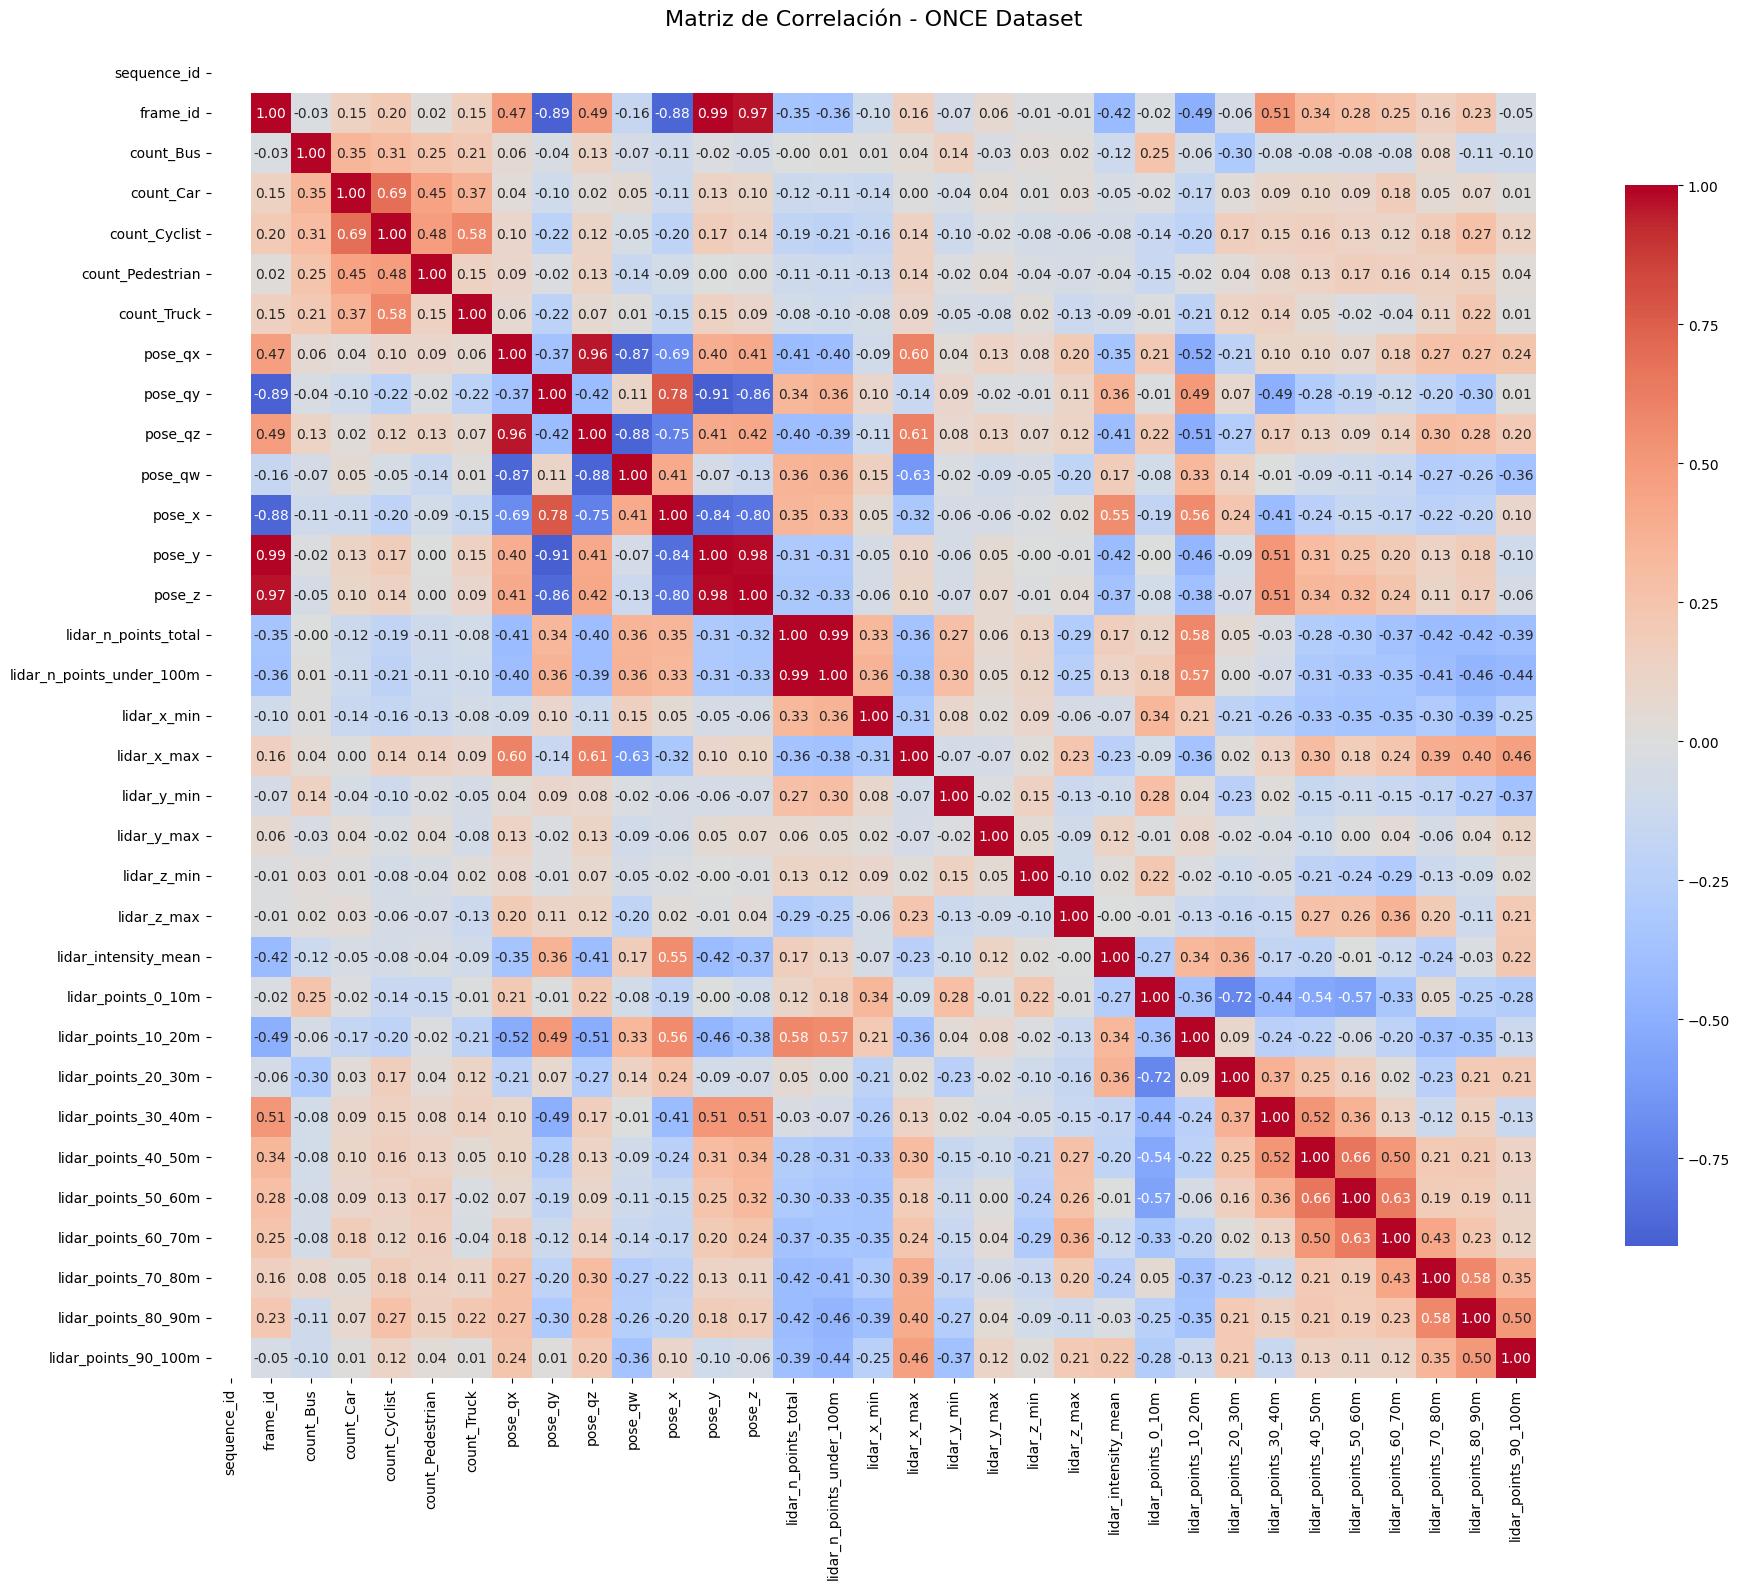

Correlaciones fuertes (>0.7 o <-0.7):
lidar_n_points_under_100m  lidar_n_points_total         0.986894
lidar_n_points_total       lidar_n_points_under_100m    0.986894
pose_y                     frame_id                     0.986785
frame_id                   pose_y                       0.986785
pose_z                     pose_y                       0.978149
pose_y                     pose_z                       0.978149
frame_id                   pose_z                       0.969271
pose_z                     frame_id                     0.969271
pose_qx                    pose_qz                      0.958080
pose_qz                    pose_qx                      0.958080
pose_x                     pose_qy                      0.776356
pose_qy                    pose_x                       0.776356
lidar_points_0_10m         lidar_points_20_30m         -0.721295
lidar_points_20_30m        lidar_points_0_10m          -0.721295
pose_qz                    pose_x                   

In [ ]:
import seaborn as sns
# Cargar un DataFrame para enseñar ejemplo de matrzi de correlación de Streamlit
df = pd.read_csv("./ONCE/data_000076.csv")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calcular matriz de correlación
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - ONCE Dataset', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Solo print correlaciones más fuertes (>0.7 o <-0.7)
strong_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix != 1.0)].stack()
print("Correlaciones fuertes (>0.7 o <-0.7):")
print(strong_corr.sort_values(ascending=False))

Aquí hacemos un análisis temporal completo de la secuencia. Primero convertimos los `frame_id` a timestamps reales para calcular la duración total y frecuencia de captura (Hz) (hemos visto que tal como mencionan en su paper originial de ONCE que entre frames hay 0.5 segundos. Recogían 10 frames por segundo pero lo dejaron en 2 frames por segundo por la variabilidad). Luego derivamos la velocidad del vehículo diferenciando la posición Y entre frames consecutivos, obteniendo velocidades en m/s y km/h. Visualizamos la trayectoria del vehículo desde múltiples perspectivas: trayectoria 2D en plano XY, evolución de la posición Y en el tiempo, perfil de velocidad, trayectoria 3D completa y distribución de los intervalos entre frames. Finalmente, generamos un resumen estadístico con métricas clave como distancia total recorrida, velocidad promedio global y consistencia temporal de la captura de datos, lo que nos permite comprender completamente la dinámica del recorrido.

C:\Users\Ander Pala\AppData\Local\Temp\ipykernel_19272\3974283057.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['frame_id'], unit='ms')


ANÁLISIS TEMPORAL:
Primer frame: 2021-04-19 02:13:16.099000
Último frame:  2021-04-19 02:21:49.600000
Duración total: 513.5 segundos
Número de frames: 935
Frecuencia: 1.82 Hz

VELOCIDAD:
Velocidad promedio en Y: -0.44 m/s (-1.6 km/h)
Velocidad máxima en Y: 6.88 m/s (24.8 km/h)


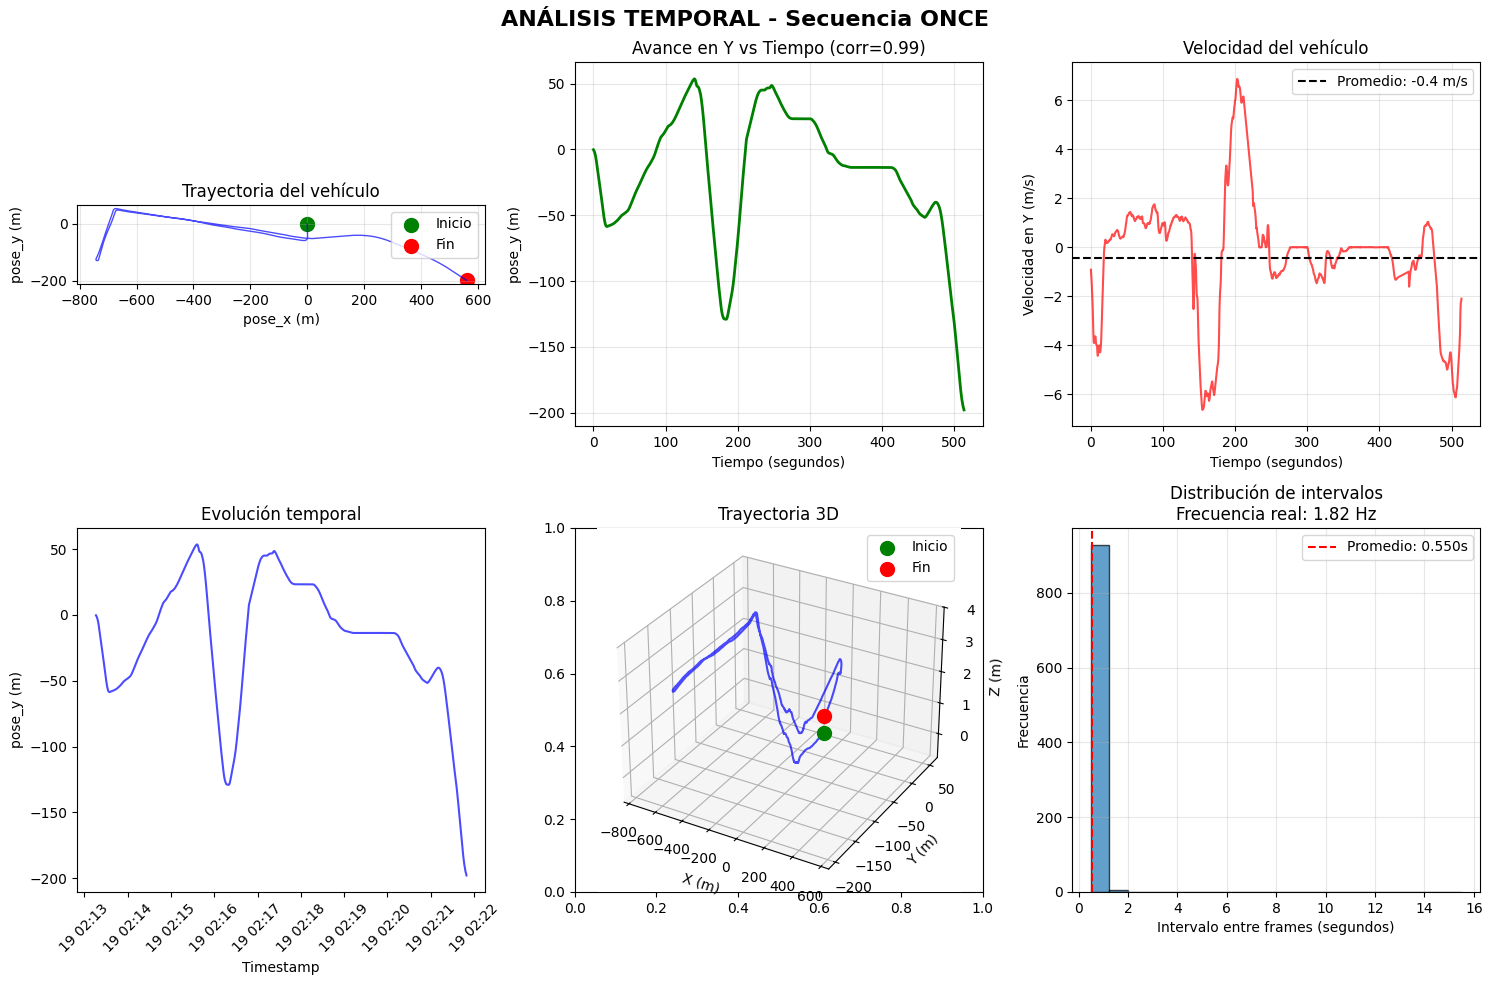


RESUMEN ESTADÍSTICO TEMPORAL:
Intervalo promedio: 0.550 ± 0.686 segundos
Frecuencia real: 1.82 Hz
Distancia total recorrida en Y: -197.7 metros
Tiempo total: 513.5 segundos
Velocidad promedio global: -0.39 m/s


In [11]:
from datetime import datetime

df['timestamp'] = pd.to_datetime(df['frame_id'], unit='ms')
# Calcular tiempo transcurrido
df = df.sort_values('timestamp')
df['time_seconds'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

print("ANÁLISIS TEMPORAL:")
print("="*50)
print(f"Primer frame: {df['timestamp'].iloc[0]}")
print(f"Último frame:  {df['timestamp'].iloc[-1]}")
print(f"Duración total: {(df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]).total_seconds():.1f} segundos")
print(f"Número de frames: {len(df)}")
print(f"Frecuencia: {len(df)/(df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]).total_seconds():.2f} Hz")

# Velocidad
df['delta_time'] = df['time_seconds'].diff()
df['delta_y'] = df['pose_y'].diff()
df['speed_y'] = df['delta_y'] / df['delta_time']  # Velocidad en Y (m/s)

print(f"\nVELOCIDAD:")
print(f"Velocidad promedio en Y: {df['speed_y'].mean():.2f} m/s ({df['speed_y'].mean()*3.6:.1f} km/h)")
print(f"Velocidad máxima en Y: {df['speed_y'].max():.2f} m/s ({df['speed_y'].max()*3.6:.1f} km/h)")

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Trayectoria en XY
axes[0,0].plot(df['pose_x'], df['pose_y'], 'b-', alpha=0.7, linewidth=1)
axes[0,0].scatter(df['pose_x'].iloc[0], df['pose_y'].iloc[0], color='green', s=100, label='Inicio')
axes[0,0].scatter(df['pose_x'].iloc[-1], df['pose_y'].iloc[-1], color='red', s=100, label='Fin')
axes[0,0].set_xlabel('pose_x (m)')
axes[0,0].set_ylabel('pose_y (m)')
axes[0,0].set_title('Trayectoria del vehículo')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_aspect('equal')

# Posición Y vs Tiempo
axes[0,1].plot(df['time_seconds'], df['pose_y'], 'g-', linewidth=2)
axes[0,1].set_xlabel('Tiempo (segundos)')
axes[0,1].set_ylabel('pose_y (m)')
axes[0,1].set_title('Avance en Y vs Tiempo (corr=0.99)')
axes[0,1].grid(True, alpha=0.3)

# Velocidad en Y
axes[0,2].plot(df['time_seconds'], df['speed_y'], 'r-', alpha=0.7)
axes[0,2].axhline(y=df['speed_y'].mean(), color='k', linestyle='--', label=f'Promedio: {df["speed_y"].mean():.1f} m/s')
axes[0,2].set_xlabel('Tiempo (segundos)')
axes[0,2].set_ylabel('Velocidad en Y (m/s)')
axes[0,2].set_title('Velocidad del vehículo')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Distribución de timestamps
axes[1,0].plot(df['timestamp'], df['pose_y'], 'b-', alpha=0.7)
axes[1,0].set_xlabel('Timestamp')
axes[1,0].set_ylabel('pose_y (m)')
axes[1,0].set_title('Evolución temporal')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Posición 3D
ax3d = fig.add_subplot(2, 3, 5, projection='3d')
ax3d.plot(df['pose_x'], df['pose_y'], df['pose_z'], 'b-', alpha=0.7)
ax3d.scatter(df['pose_x'].iloc[0], df['pose_y'].iloc[0], df['pose_z'].iloc[0], 
            color='green', s=100, label='Inicio')
ax3d.scatter(df['pose_x'].iloc[-1], df['pose_y'].iloc[-1], df['pose_z'].iloc[-1], 
            color='red', s=100, label='Fin')
ax3d.set_xlabel('X (m)')
ax3d.set_ylabel('Y (m)')
ax3d.set_zlabel('Z (m)')
ax3d.set_title('Trayectoria 3D')
ax3d.legend()

# 6. Histograma de intervalos
time_diffs = df['timestamp'].diff().dt.total_seconds().dropna()
axes[1,2].hist(time_diffs, bins=20, edgecolor='black', alpha=0.7)
axes[1,2].axvline(x=time_diffs.mean(), color='red', linestyle='--', 
                  label=f'Promedio: {time_diffs.mean():.3f}s')
axes[1,2].set_xlabel('Intervalo entre frames (segundos)')
axes[1,2].set_ylabel('Frecuencia')
axes[1,2].set_title(f'Distribución de intervalos\nFrecuencia real: {1/time_diffs.mean():.2f} Hz')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.suptitle('ANÁLISIS TEMPORAL - Secuencia ONCE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumen estadístico
print("\nRESUMEN ESTADÍSTICO TEMPORAL:")
print("="*50)
print(f"Intervalo promedio: {time_diffs.mean():.3f} ± {time_diffs.std():.3f} segundos")
print(f"Frecuencia real: {1/time_diffs.mean():.2f} Hz")
print(f"Distancia total recorrida en Y: {df['pose_y'].iloc[-1] - df['pose_y'].iloc[0]:.1f} metros")
print(f"Tiempo total: {df['time_seconds'].iloc[-1]:.1f} segundos")
print(f"Velocidad promedio global: {(df['pose_y'].iloc[-1] - df['pose_y'].iloc[0])/df['time_seconds'].iloc[-1]:.2f} m/s")

Analizamos el comportamiento de conducción detectando paradas (tiempo detenido), clasificando velocidades en categorías, calculando aceleración e identificando curvas significativas. Visualizamos el perfil de velocidad, su distribución, y mapeamos velocidad sobre la trayectoria. Los datos muestran conducción urbana lenta y características realistas que los modelos ML deben considerar para manejar esta temporalidad y baja velocidad.

ANÁLISIS DE LA CONDUCCIÓN:
1. TIEMPO DETENIDO: 169.0s (32.9%)

DISTRIBUCIÓN DE VELOCIDADES:
   Parado (<5): 72.3%
   Lento (10-20): 11.5%
   Normal (20-30): 8.5%
   Muy lento (5-10): 7.8%
   Rápido (>30): 0.0%

3. ACELERACIÓN: Promedio=0.002 m/s², Máx=2.142 m/s²

4. CURVAS: 933 frames con cambios de dirección


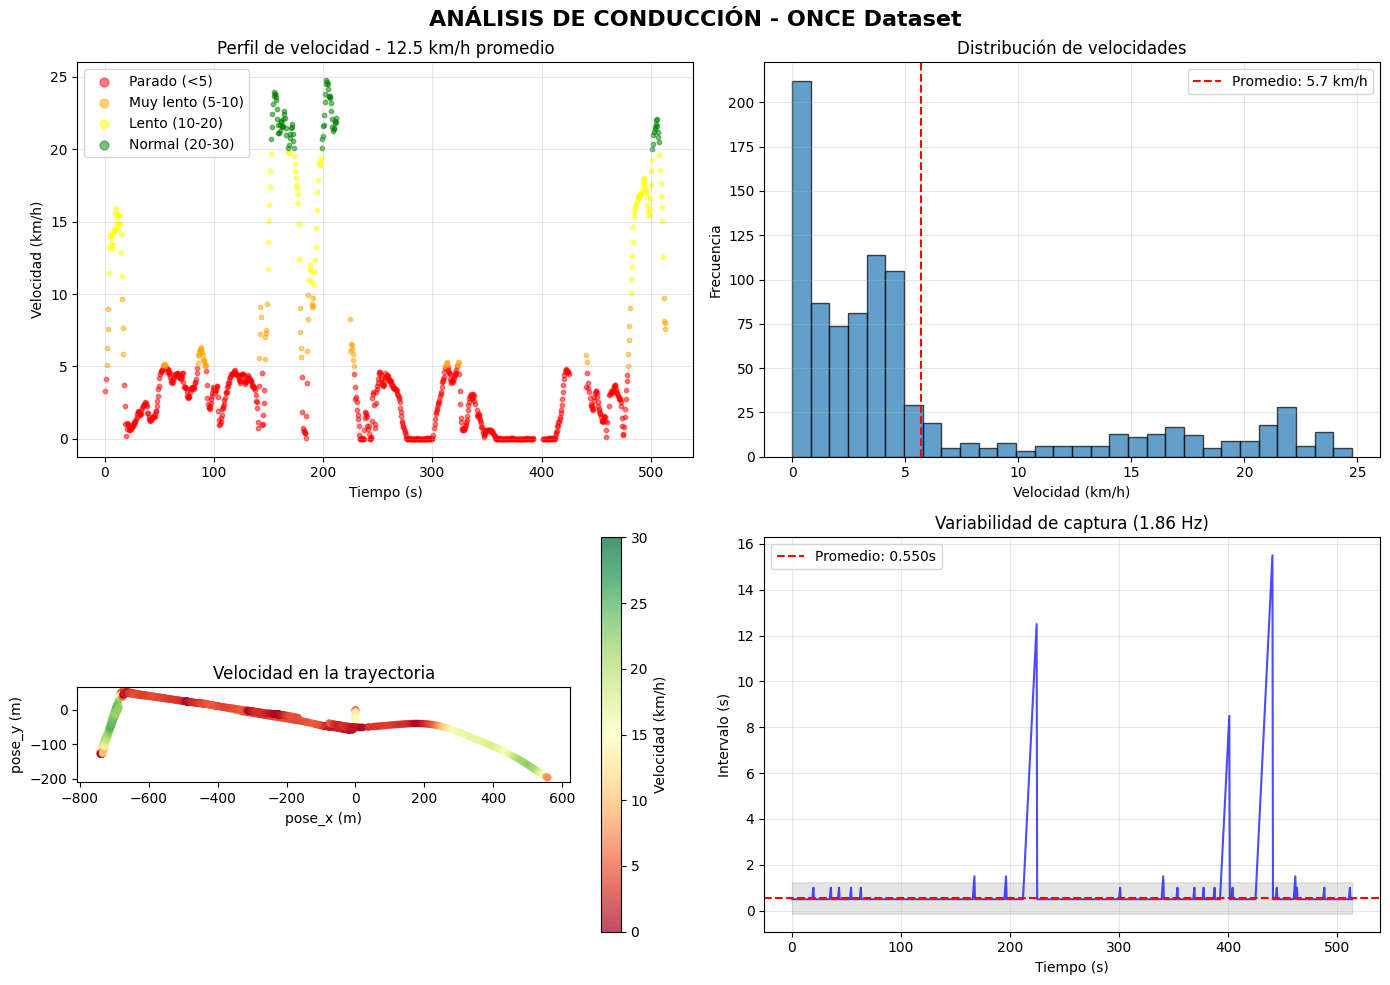

In [12]:
# Análisis más profundo
print("ANÁLISIS DE LA CONDUCCIÓN:")
print("="*50)

# Detectar paradas (velocidad < 0.5 m/s)
df['stopped'] = df['speed_y'].abs() < 0.5
stopped_time = df[df['stopped']]['delta_time'].sum()
print(f"1. TIEMPO DETENIDO: {stopped_time:.1f}s ({(stopped_time/df['time_seconds'].iloc[-1])*100:.1f}%)")

# Segmentos por velocidad
df['speed_kmh'] = df['speed_y'] * 3.6
df['speed_category'] = pd.cut(df['speed_kmh'].abs(), 
                               bins=[0, 5, 10, 20, 30, 100],
                               labels=['Parado (<5)', 'Muy lento (5-10)', 
                                       'Lento (10-20)', 'Normal (20-30)', 'Rápido (>30)'])

print(f"\nDISTRIBUCIÓN DE VELOCIDADES:")
speed_dist = df['speed_category'].value_counts(normalize=True) * 100
for cat, perc in speed_dist.items():
    print(f"   {cat}: {perc:.1f}%")

# Aceleraciones
df['acceleration'] = df['speed_y'].diff() / df['delta_time']
print(f"\n3. ACELERACIÓN: Promedio={df['acceleration'].mean():.3f} m/s², Máx={df['acceleration'].abs().max():.3f} m/s²")

# Análisis de dirección
# Calcular cambio de dirección 
df['heading_change'] = np.arctan2(df['pose_x'].diff(), df['pose_y'].diff())
df['turning'] = df['heading_change'].abs() > 0.1  # Cambios > 0.1 rad

turning_segments = df['turning'].sum()
print(f"\n4. CURVAS: {turning_segments} frames con cambios de dirección")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Velocidad vs Tiempo con categorías
colors = {'Parado (<5)': 'red', 'Muy lento (5-10)': 'orange', 
          'Lento (10-20)': 'yellow', 'Normal (20-30)': 'green', 'Rápido (>30)': 'blue'}
for cat, color in colors.items():
    mask = df['speed_category'] == cat
    if mask.any():
        axes[0,0].scatter(df.loc[mask, 'time_seconds'], 
                         df.loc[mask, 'speed_kmh'].abs(),
                         color=color, s=10, alpha=0.5, label=cat)

axes[0,0].set_xlabel('Tiempo (s)')
axes[0,0].set_ylabel('Velocidad (km/h)')
axes[0,0].set_title('Perfil de velocidad - 12.5 km/h promedio')
axes[0,0].legend(markerscale=2)
axes[0,0].grid(True, alpha=0.3)

# Histograma de velocidad
axes[0,1].hist(df['speed_kmh'].abs(), bins=30, edgecolor='black', alpha=0.7)
axes[0,1].axvline(x=df['speed_kmh'].abs().mean(), color='red', 
                  linestyle='--', label=f'Promedio: {df["speed_kmh"].abs().mean():.1f} km/h')
axes[0,1].set_xlabel('Velocidad (km/h)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_title('Distribución de velocidades')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Mapa de calor velocidad-posición
scatter = axes[1,0].scatter(df['pose_x'], df['pose_y'], 
                           c=df['speed_kmh'].abs(), 
                           cmap='RdYlGn', s=20, alpha=0.7,
                           vmin=0, vmax=30)
axes[1,0].set_xlabel('pose_x (m)')
axes[1,0].set_ylabel('pose_y (m)')
axes[1,0].set_title('Velocidad en la trayectoria')
axes[1,0].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1,0], label='Velocidad (km/h)')

# Intervalos entre frames
axes[1,1].plot(df['time_seconds'][1:], time_diffs, 'b-', alpha=0.7)
axes[1,1].axhline(y=time_diffs.mean(), color='r', linestyle='--', 
                  label=f'Promedio: {time_diffs.mean():.3f}s')
axes[1,1].fill_between(df['time_seconds'][1:], 
                       time_diffs.mean() - time_diffs.std(),
                       time_diffs.mean() + time_diffs.std(),
                       alpha=0.2, color='gray')
axes[1,1].set_xlabel('Tiempo (s)')
axes[1,1].set_ylabel('Intervalo (s)')
axes[1,1].set_title('Variabilidad de captura (1.86 Hz)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('ANÁLISIS DE CONDUCCIÓN - ONCE Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### **Merge de todas las secuancias**

In [1]:
import pandas as pd

df76 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000076.csv")
df80 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000080.csv")
df92 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000092.csv")
df104 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000104.csv")
df113 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000113.csv")
df121 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000121.csv")

df27 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000027.csv")
df28 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000028.csv")
df112 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000112.csv")
df201 = df = pd.read_csv("../../../ONCE/frame_summary_with_lidar_000201.csv")


df_total = pd.concat([df76, df80, df92, df104, df113, df121, df27, df28, df112, df201], ignore_index=True)


df_total.to_csv("./data.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../../ONCE/frame_summary_with_lidar_000076.csv'

In [2]:
import pandas as pd
df_total = pd.read_csv("./data.csv", index_col=False)
df_total.head()

,sequence_id,frame_id,has_annotations,count_Bus,count_Car,count_Cyclist,count_Pedestrian,count_Truck,pose_qx,pose_qy,...,lidar_points_0_10m,lidar_points_10_20m,lidar_points_20_30m,lidar_points_30_40m,lidar_points_40_50m,lidar_points_50_60m,lidar_points_60_70m,lidar_points_70_80m,lidar_points_80_90m,lidar_points_90_100m
0,76,1616343527200,True,0,19,7,1,1,0.000243,0.000177,...,12466,26391,7973,4380,3100,1442,1558,936,1010,1105
1,76,1616343527700,False,0,0,0,0,0,0.000300,0.002447,...,12856,25778,8022,4838,3055,1983,1309,987,1120,1220
2,76,1616343528200,True,0,22,4,2,1,0.001423,0.004896,...,13344,24436,8874,4870,3006,2395,1365,936,956,1252
3,76,1616343528700,False,0,0,0,0,0,0.001635,0.004908,...,14341,22663,9081,5269,3336,2439,1286,1125,965,1429
4,76,1616343529200,True,0,18,3,0,1,0.002884,0.000735,...,15803,19961,9658,5869,3714,1894,1283,1226,1080,1471


Analizamos las trayectorias del vehículo por secuencia, mostrando las rutas recorridas en planos 2D con puntos de inicio (verde) y fin (rojo). Visualizamos todas las trayectorias superpuestas para comparar patrones de conducción. Calculamos estadísticas comparativas entre secuencias: duración, distancia recorrida, velocidad promedio, número de frames, densidad de puntos LiDAR cercanos y frecuencia de captura. Analizamos la distribución de objetos detectados (coches, camiones, etc.) por secuencia y finalmente, generamos mapas de calor que muestran la velocidad en cada punto de las trayectorias, usando colores para representar la intensidad del movimiento.

/tmp/ipykernel_8501/4204806170.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
/tmp/ipykernel_8501/4204806170.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
/tmp/ipykernel_8501/4204806170.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

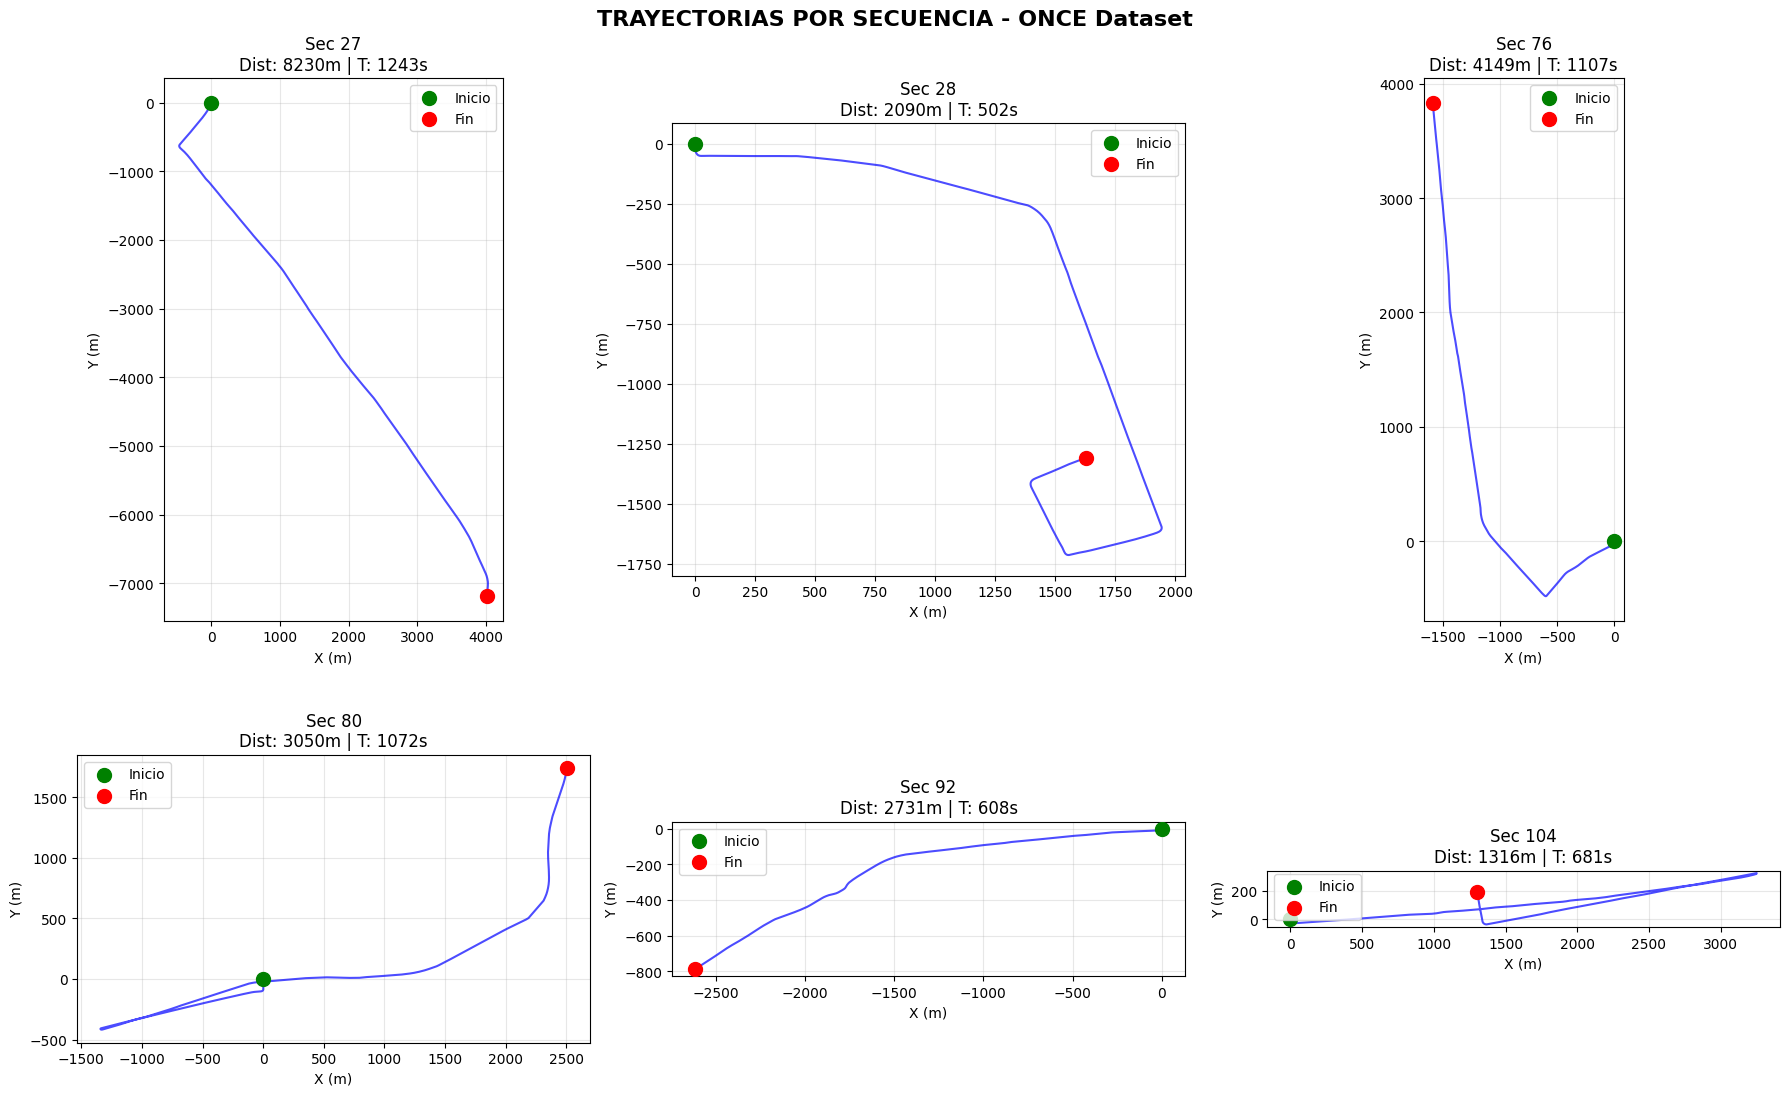

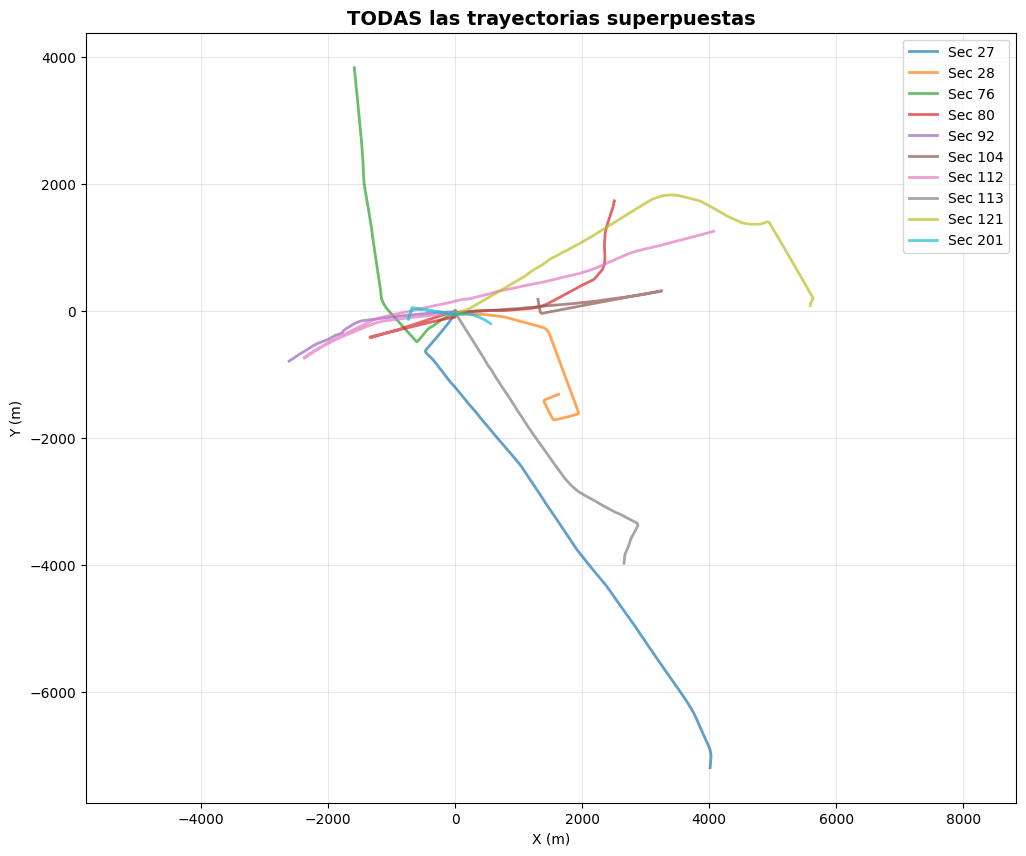

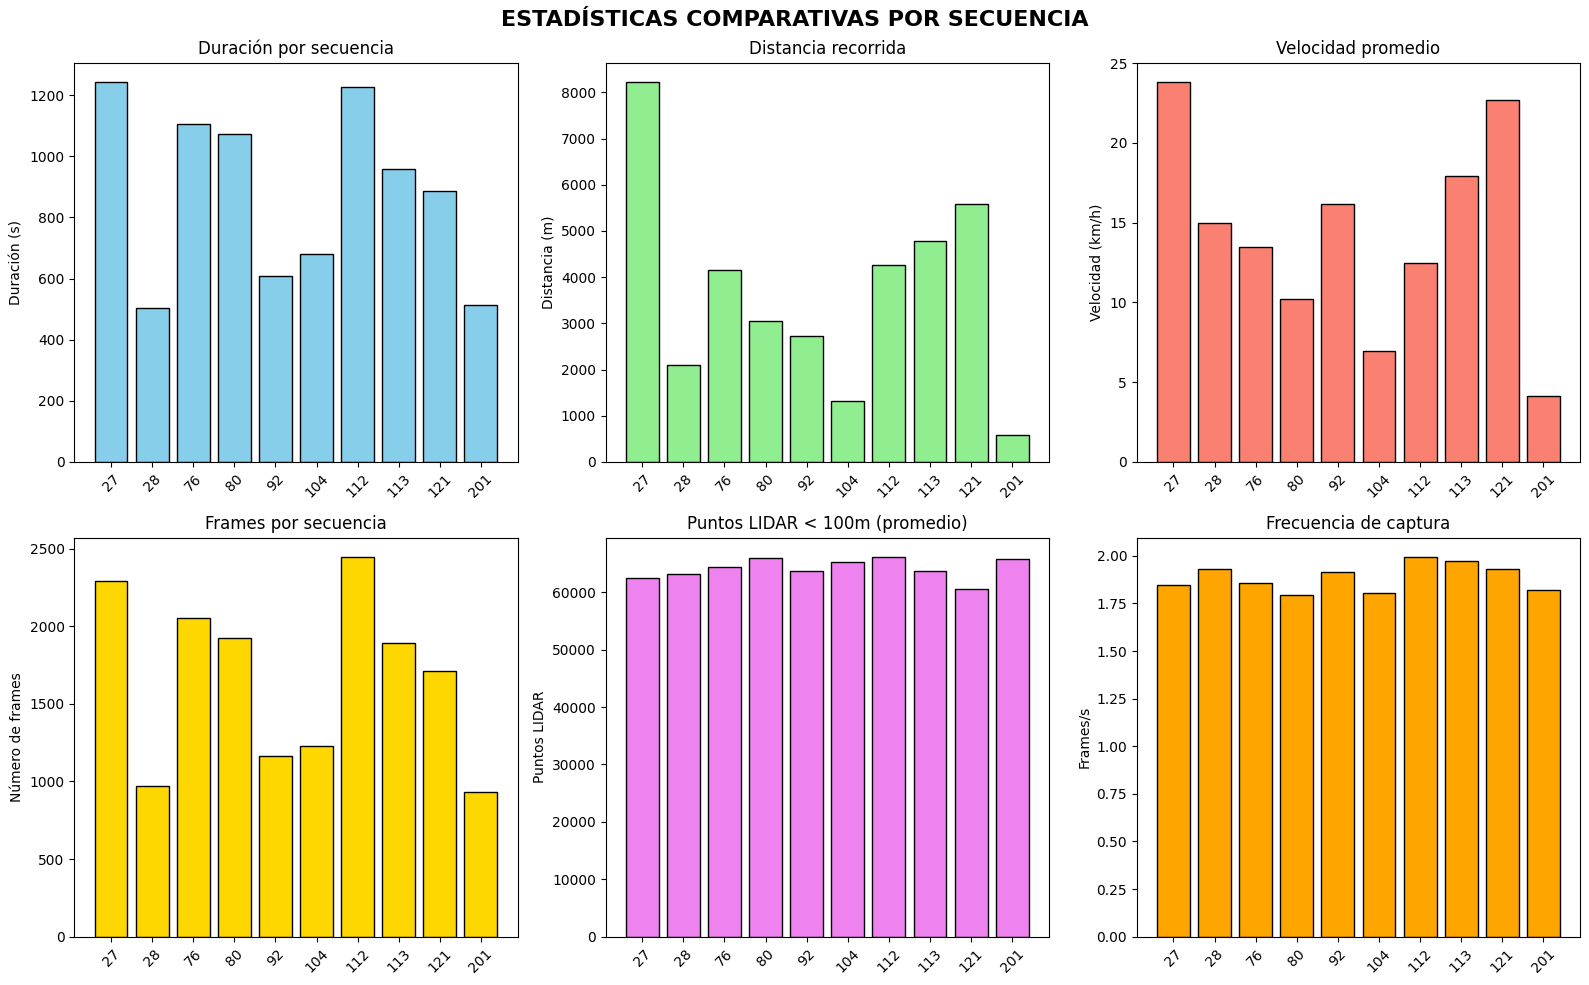

RESUMEN POR SECUENCIA:
Secuencia  Frames   Duración(s)  Distancia(m) Vel(km/h)  LIDAR pts 
--------------------------------------------------------------------------------
27.0       2294.0   1243         8230         23.8       62497     
28.0       970.0    502          2090         15.0       63130     
76.0       2055.0   1107         4149         13.5       64343     
80.0       1922.0   1072         3050         10.2       66003     
92.0       1165.0   608          2731         16.2       63642     
104.0      1230.0   681          1316         7.0        65301     
112.0      2449.0   1227         4259         12.5       66217     
113.0      1891.0   960          4775         17.9       63629     
121.0      1714.0   887          5590         22.7       60512     
201.0      935.0    514          593          4.2        65836     

 DISTRIBUCIÓN DE OBJETOS DETECTADOS:
             Bus    Car  Cyclist  Pedestrian  Truck
sequence_id                                        
27    

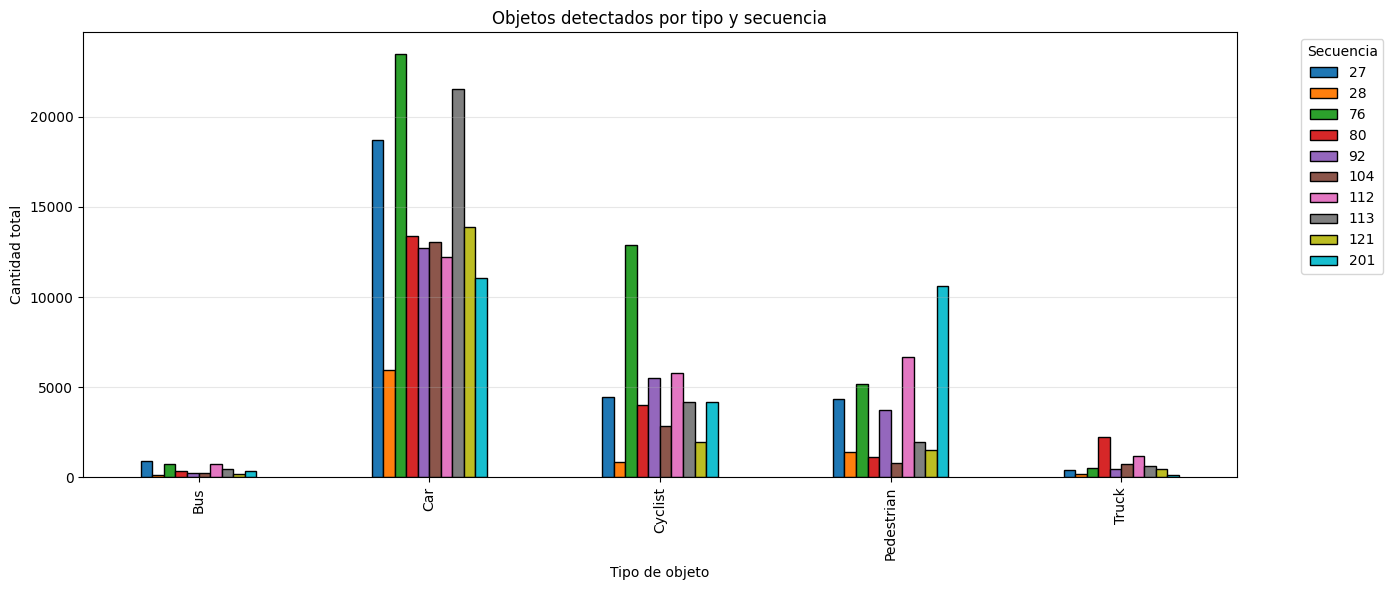

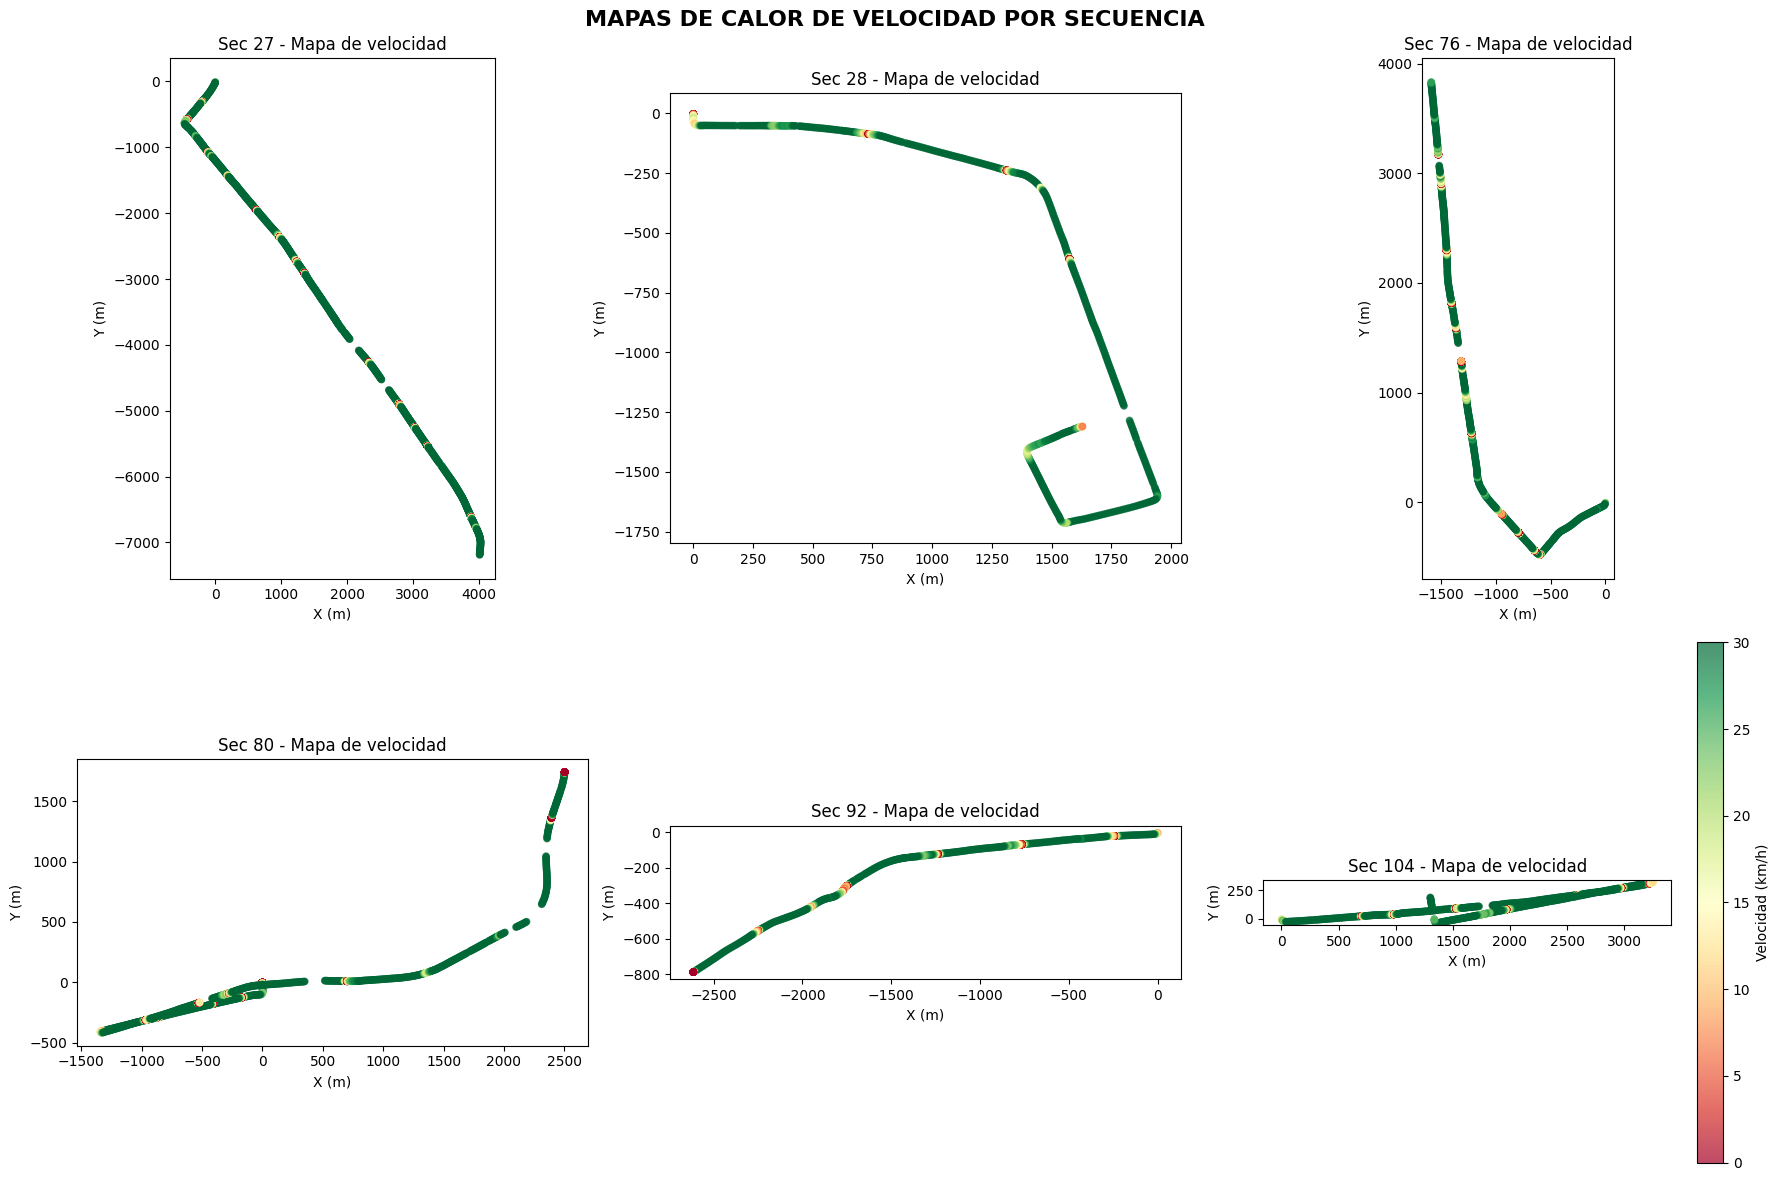

In [4]:
# Análisis de trayectorias por secuencia
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# Agrupar por sequence_id
grouped = df_total.groupby('sequence_id')
# Obtener las 6 secuencias principales
sequences_ids = sorted(df_total['sequence_id'].unique())[:6]

for idx, seq_id in enumerate(sequences_ids):
    df_seq = grouped.get_group(seq_id)
    ax = axes.flat[idx]
    
    # Trayectoria XY
    ax.plot(df_seq['pose_x'], df_seq['pose_y'], 'b-', alpha=0.7, linewidth=1.5)
    ax.scatter(df_seq['pose_x'].iloc[0], df_seq['pose_y'].iloc[0], 
               color='green', s=100, label='Inicio', zorder=5)
    ax.scatter(df_seq['pose_x'].iloc[-1], df_seq['pose_y'].iloc[-1], 
               color='red', s=100, label='Fin', zorder=5)
    
    # Estadísticas
    distancia = np.sqrt((df_seq['pose_x'].iloc[-1] - df_seq['pose_x'].iloc[0])**2 + 
                       (df_seq['pose_y'].iloc[-1] - df_seq['pose_y'].iloc[0])**2)
    
    # Calcular duración desde frame_id (timestamps)
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    duracion = (df_seq['timestamp'].iloc[-1] - df_seq['timestamp'].iloc[0]).total_seconds()
    
    ax.set_title(f'Sec {seq_id}\nDist: {distancia:.0f}m | T: {duracion:.0f}s')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_aspect('equal')

plt.suptitle('TRAYECTORIAS POR SECUENCIA - ONCE Dataset', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Todas las trayectorias en un plot
plt.figure(figsize=(12, 10))
for seq_id, group in grouped:
    plt.plot(group['pose_x'], group['pose_y'], '-', linewidth=2, 
             alpha=0.7, label=f'Sec {seq_id}')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('TODAS las trayectorias superpuestas', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


# Estadísticas comparativas
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Calcular estadísticas para cada secuencia
stats_list = []
for seq_id, group in grouped:
    group = group.copy()
    group['timestamp'] = pd.to_datetime(group['frame_id'], unit='ms')
    group = group.sort_values('timestamp')
    
    # Distancia
    dx = group['pose_x'].iloc[-1] - group['pose_x'].iloc[0]
    dy = group['pose_y'].iloc[-1] - group['pose_y'].iloc[0]
    distancia = np.sqrt(dx**2 + dy**2)
    
    # Duración
    duracion = (group['timestamp'].iloc[-1] - group['timestamp'].iloc[0]).total_seconds()
    
    # Velocidad promedio
    velocidad = (distancia / duracion * 3.6) if duracion > 0 else 0
    
    # Puntos LIDAR promedio
    lidar_prom = group['lidar_n_points_under_100m'].mean() if 'lidar_n_points_under_100m' in group.columns else 0
    
    stats_list.append({
        'seq_id': seq_id,
        'frames': len(group),
        'duracion': duracion,
        'distancia': distancia,
        'velocidad': velocidad,
        'lidar_prom': lidar_prom
    })

# Convertir a DataFrame
stats_df = pd.DataFrame(stats_list)
seq_ids = stats_df['seq_id'].astype(str)
#  Duración
axes[0,0].bar(seq_ids, stats_df['duracion'], color='skyblue', edgecolor='black')
axes[0,0].set_ylabel('Duración (s)')
axes[0,0].set_title('Duración por secuencia')
axes[0,0].tick_params(axis='x', rotation=45)
# Distancia
axes[0,1].bar(seq_ids, stats_df['distancia'], color='lightgreen', edgecolor='black')
axes[0,1].set_ylabel('Distancia (m)')
axes[0,1].set_title('Distancia recorrida')
axes[0,1].tick_params(axis='x', rotation=45)
# Velocidad
axes[0,2].bar(seq_ids, stats_df['velocidad'], color='salmon', edgecolor='black')
axes[0,2].set_ylabel('Velocidad (km/h)')
axes[0,2].set_title('Velocidad promedio')
axes[0,2].tick_params(axis='x', rotation=45)
# Frames
axes[1,0].bar(seq_ids, stats_df['frames'], color='gold', edgecolor='black')
axes[1,0].set_ylabel('Número de frames')
axes[1,0].set_title('Frames por secuencia')
axes[1,0].tick_params(axis='x', rotation=45)
# Puntos LIDAR
if 'lidar_prom' in stats_df.columns:
    axes[1,1].bar(seq_ids, stats_df['lidar_prom'], color='violet', edgecolor='black')
    axes[1,1].set_ylabel('Puntos LIDAR')
    axes[1,1].set_title('Puntos LIDAR < 100m (promedio)')
    axes[1,1].tick_params(axis='x', rotation=45)
# Densidad de frames (frames/segundo)
axes[1,2].bar(seq_ids, stats_df['frames'] / stats_df['duracion'], color='orange', edgecolor='black')
axes[1,2].set_ylabel('Frames/s')
axes[1,2].set_title('Frecuencia de captura')
axes[1,2].tick_params(axis='x', rotation=45)

plt.suptitle('ESTADÍSTICAS COMPARATIVAS POR SECUENCIA', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Tabla para enseñar un resumen
print("RESUMEN POR SECUENCIA:")
print("="*80)
print(f"{'Secuencia':<10} {'Frames':<8} {'Duración(s)':<12} {'Distancia(m)':<12} {'Vel(km/h)':<10} {'LIDAR pts':<10}")
print("-"*80)

for _, row in stats_df.iterrows():
    print(f"{row['seq_id']:<10} {row['frames']:<8} {row['duracion']:<12.0f} {row['distancia']:<12.0f} {row['velocidad']:<10.1f} {row['lidar_prom']:<10.0f}")

# Distribución de objetos detectados
count_cols = [col for col in df_total.columns if col.startswith('count_')]
if count_cols:
    print("\n DISTRIBUCIÓN DE OBJETOS DETECTADOS:")
    print("="*80)
    
    # Agrupar por secuencia y sumar
    obj_counts = df_total.groupby('sequence_id')[count_cols].sum()
    obj_counts.columns = [col.replace('count_', '') for col in obj_counts.columns]
    print(obj_counts)
    
    # Plot
    obj_counts.T.plot(kind='bar', figsize=(14, 6), edgecolor='black')
    plt.title('Objetos detectados por tipo y secuencia')
    plt.xlabel('Tipo de objeto')
    plt.ylabel('Cantidad total')
    plt.legend(title='Secuencia', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Heatmap de velocidades por secuencia
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (seq_id, ax) in enumerate(zip(sequences_ids, axes.flat)):
    df_seq = grouped.get_group(seq_id).copy()
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq = df_seq.sort_values('timestamp')
    df_seq['speed'] = np.sqrt(df_seq['pose_x'].diff()**2 + 
                             df_seq['pose_y'].diff()**2) / \
                     df_seq['timestamp'].diff().dt.total_seconds()
    scatter = ax.scatter(df_seq['pose_x'], df_seq['pose_y'], 
                        c=df_seq['speed'].abs() * 3.6,  # km/h
                        cmap='RdYlGn', s=20, alpha=0.7,
                        vmin=0, vmax=30)
    ax.set_title(f'Sec {seq_id} - Mapa de velocidad')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    if idx == len(sequences_ids) - 1:
        plt.colorbar(scatter, ax=ax, label='Velocidad (km/h)')

plt.suptitle('MAPAS DE CALOR DE VELOCIDAD POR SECUENCIA', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Analizamos cada secuencia por separado para ver su comportamiento de conducción. Para cada una, calculamos métricas como: duración total, porcentaje de tiempo detenido (velocidad < 0.5 m/s), velocidad promedio, aceleración máxima y promedio, y número de curvas significativas detectadas. También clasificamos la velocidad en categorías (Parado, Muy lento, Lento, Normal, Rápido) y mostramos su distribución porcentual. Visualizamos cada secuencia con cuatro gráficos: trayectoria coloreada por velocidad, evolución temporal de la velocidad, histograma de distribución de velocidades y análisis de la frecuencia de captura (Hz). Finalmente, generamos una tabla comparativa resumiendo todas las métricas por secuencia y concluimos que los datos muestran conducción urbana típica con velocidades bajas (<30 km/h), alta variabilidad entre secuencias, y representatividad de condiciones reales de ciudad.

ANÁLISIS MÁS DETALLADO POR SECUENCIA

SECUENCIA 27:
----------------------------------------
1. DURACIÓN TOTAL: 1243s
2. TIEMPO DETENIDO: 425s (34.2%)
3. VELOCIDAD PROMEDIO: 20.9 km/h
4. ACELERACIÓN: Prom=-0.006 m/s², Máx=3.668 m/s²
5. CURVAS: 2275 frames (99.2%)

DISTRIBUCIÓN DE VELOCIDADES:
   • Rápido (>30): 40.6%
   • Parado (<5): 37.3%
   • Normal (20-30): 10.5%
   • Lento (10-20): 8.0%
   • Muy lento (5-10): 3.6%

SECUENCIA 28:
----------------------------------------
1. DURACIÓN TOTAL: 502s
2. TIEMPO DETENIDO: 177s (35.2%)
3. VELOCIDAD PROMEDIO: 15.1 km/h
4. ACELERACIÓN: Prom=0.009 m/s², Máx=4.514 m/s²
5. CURVAS: 961 frames (99.1%)

DISTRIBUCIÓN DE VELOCIDADES:
   • Parado (<5): 44.8%
   • Rápido (>30): 22.7%
   • Lento (10-20): 21.7%
   • Muy lento (5-10): 6.8%
   • Normal (20-30): 4.0%

SECUENCIA 76:
----------------------------------------
1. DURACIÓN TOTAL: 1107s
2. TIEMPO DETENIDO: 514s (46.4%)
3. VELOCIDAD PROMEDIO: 15.4 km/h
4. ACELERACIÓN: Prom=0.006 m/s², Máx=15.730 m/s

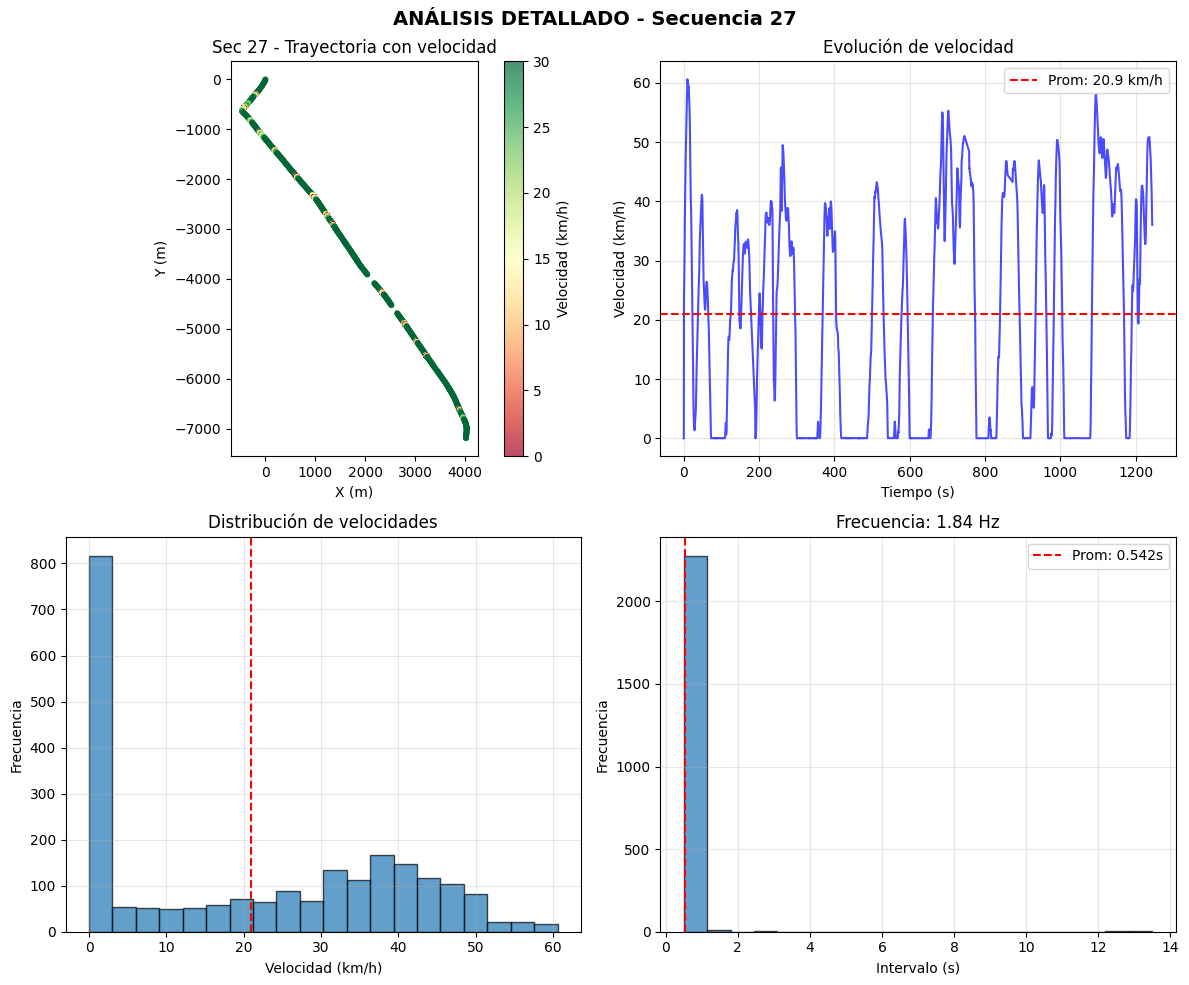

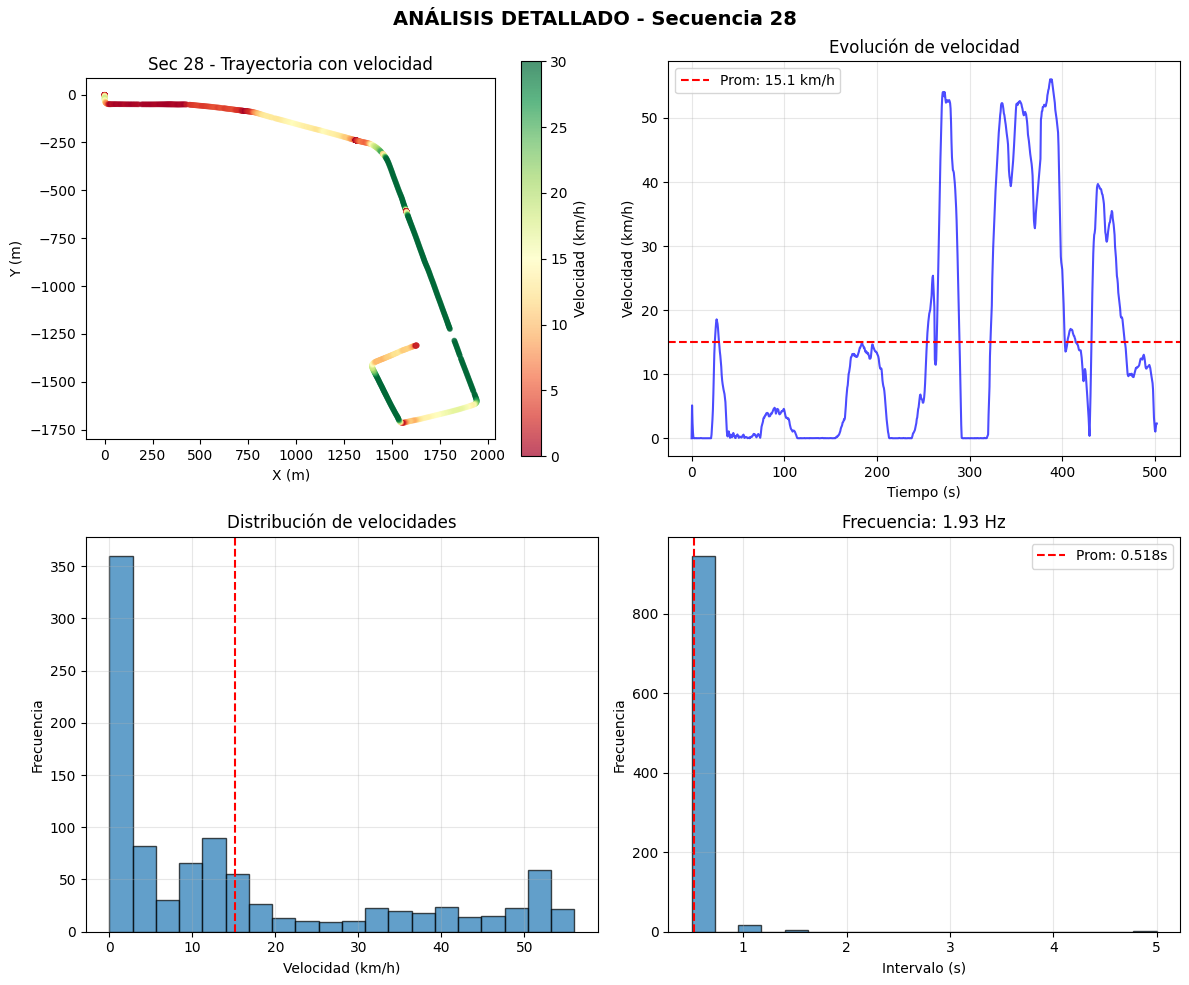

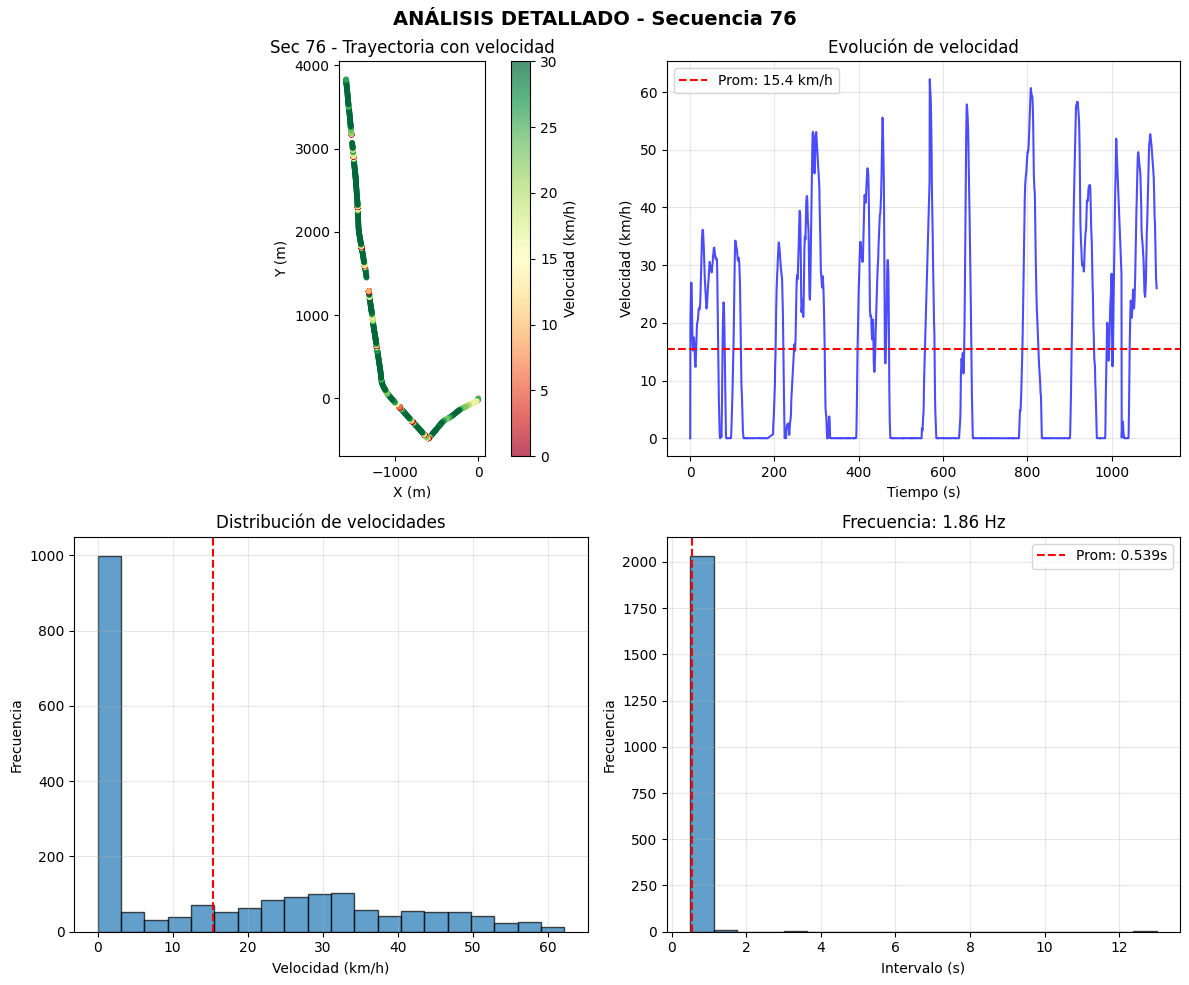

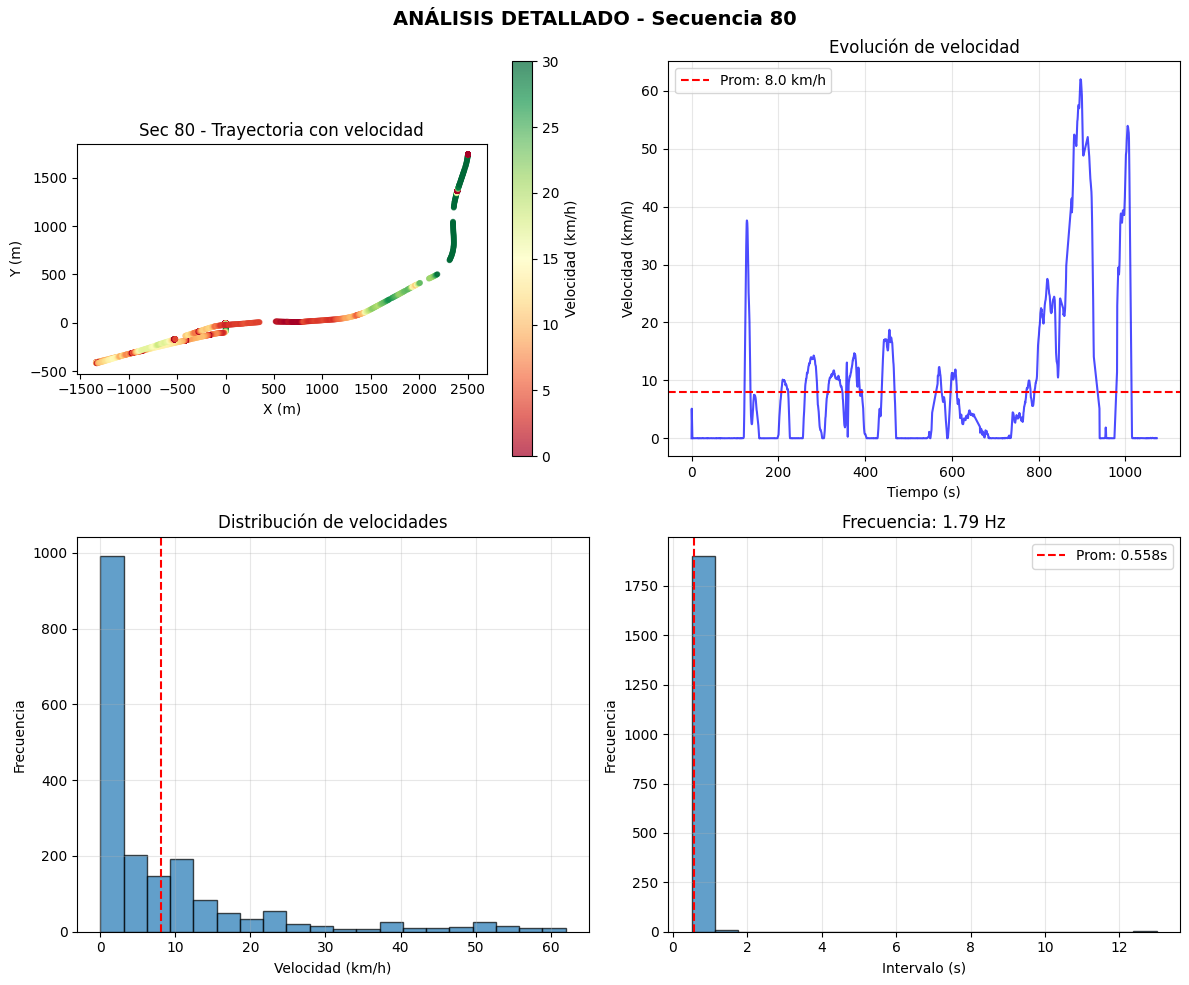


RESUMEN COMPARATIVO FINAL
 Secuencia  Frames  Duración (s)  Distancia (m)  Velocidad (km/h)  % Paradas  Puntos LIDAR
        27    2294      1243.499    8229.592676         20.930342  33.696600  62497.366609
        28     970       502.001    2089.963524         15.086524  35.257732  63130.442268
        76    2055      1106.999    4148.795280         15.429484  46.812652  64343.445742
        80    1922      1072.000    3049.517961          8.009184  48.751301  66002.897503
        92    1165       608.000    2730.667672          4.774189  53.905579  63642.321888
       104    1230       681.498    1316.220052          4.913431  34.959350  65300.724390
       112    2449      1227.000    4259.032140          8.038801  31.808902  66217.456921
       113    1891       959.500    4775.121012         15.102886  43.997885  63628.974617
       121    1714       887.499    5590.025108         15.179193  30.513419  60511.953326
       201     935       513.501     592.886887          5.7001

In [5]:
# Agrupar por secuencia
grouped = df_total.groupby('sequence_id')

print("ANÁLISIS MÁS DETALLADO POR SECUENCIA")
print("="*80)

# Para cada secuencia
for seq_id, df_seq in grouped:
    print(f"\nSECUENCIA {seq_id}:")
    print("-"*40)
    
    # Preparar datos temporales
    df_seq = df_seq.copy()
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq = df_seq.sort_values('timestamp')
    df_seq['time_seconds'] = (df_seq['timestamp'] - df_seq['timestamp'].iloc[0]).dt.total_seconds()
    # Calcular velocidad en Y (asumiendo que Y es la dirección principal)
    df_seq['delta_time'] = df_seq['time_seconds'].diff()
    df_seq['delta_y'] = df_seq['pose_y'].diff()
    df_seq['speed_y'] = df_seq['delta_y'] / df_seq['delta_time']
    # Paradas
    df_seq['stopped'] = df_seq['speed_y'].abs() < 0.5
    stopped_time = df_seq[df_seq['stopped']]['delta_time'].sum()
    total_time = df_seq['time_seconds'].iloc[-1]
    # Categorías de velocidad
    df_seq['speed_kmh'] = df_seq['speed_y'].abs() * 3.6
    df_seq['speed_category'] = pd.cut(df_seq['speed_kmh'], 
                                       bins=[0, 5, 10, 20, 30, 100],
                                       labels=['Parado (<5)', 'Muy lento (5-10)', 
                                               'Lento (10-20)', 'Normal (20-30)', 'Rápido (>30)'])
    # Aceleración
    df_seq['acceleration'] = df_seq['speed_y'].diff() / df_seq['delta_time']
    # Cambios de dirección
    df_seq['heading_change'] = np.arctan2(df_seq['pose_x'].diff(), df_seq['pose_y'].diff())
    df_seq['turning'] = df_seq['heading_change'].abs() > 0.1
    
    # Resultados para cada secuencia
    print(f"1. DURACIÓN TOTAL: {total_time:.0f}s")
    print(f"2. TIEMPO DETENIDO: {stopped_time:.0f}s ({stopped_time/total_time*100:.1f}%)")
    print(f"3. VELOCIDAD PROMEDIO: {df_seq['speed_kmh'].mean():.1f} km/h")
    print(f"4. ACELERACIÓN: Prom={df_seq['acceleration'].mean():.3f} m/s², Máx={df_seq['acceleration'].abs().max():.3f} m/s²")
    print(f"5. CURVAS: {df_seq['turning'].sum()} frames ({df_seq['turning'].sum()/len(df_seq)*100:.1f}%)")
    
    # Distribución de velocidades
    speed_dist = df_seq['speed_category'].value_counts(normalize=True) * 100
    print("\nDISTRIBUCIÓN DE VELOCIDADES:")
    for cat, perc in speed_dist.items():
        print(f"   • {cat}: {perc:.1f}%")

print("\n" + "="*80)
print("VISUALIZACIONES POR SECUENCIA")
print("="*80)

# isualizaciones para cada secuencia
for seq_id, df_seq in list(grouped)[:4]: 
    df_seq = df_seq.copy()
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq = df_seq.sort_values('timestamp')
    df_seq['time_seconds'] = (df_seq['timestamp'] - df_seq['timestamp'].iloc[0]).dt.total_seconds()
    df_seq['delta_time'] = df_seq['time_seconds'].diff()
    df_seq['speed_kmh'] = df_seq['pose_y'].diff().abs() / df_seq['delta_time'] * 3.6
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Trayectoria con velocidad
    scatter1 = axes[0,0].scatter(df_seq['pose_x'], df_seq['pose_y'], 
                                c=df_seq['speed_kmh'].fillna(0), 
                                cmap='RdYlGn', s=10, alpha=0.7, vmin=0, vmax=30)
    axes[0,0].set_xlabel('X (m)')
    axes[0,0].set_ylabel('Y (m)')
    axes[0,0].set_title(f'Sec {seq_id} - Trayectoria con velocidad')
    axes[0,0].set_aspect('equal')
    plt.colorbar(scatter1, ax=axes[0,0], label='Velocidad (km/h)')
    
    # Velocidad vs tiempo
    axes[0,1].plot(df_seq['time_seconds'], df_seq['speed_kmh'].fillna(0), 'b-', alpha=0.7)
    axes[0,1].axhline(y=df_seq['speed_kmh'].mean(), color='r', linestyle='--', 
                     label=f'Prom: {df_seq["speed_kmh"].mean():.1f} km/h')
    axes[0,1].set_xlabel('Tiempo (s)')
    axes[0,1].set_ylabel('Velocidad (km/h)')
    axes[0,1].set_title('Evolución de velocidad')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Histograma de velocidad
    axes[1,0].hist(df_seq['speed_kmh'].fillna(0), bins=20, edgecolor='black', alpha=0.7)
    axes[1,0].axvline(x=df_seq['speed_kmh'].mean(), color='r', linestyle='--')
    axes[1,0].set_xlabel('Velocidad (km/h)')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].set_title('Distribución de velocidades')
    axes[1,0].grid(True, alpha=0.3)
    
    # Intervalos entre frames
    time_diffs = df_seq['timestamp'].diff().dt.total_seconds().dropna()
    axes[1,1].hist(time_diffs, bins=20, edgecolor='black', alpha=0.7)
    axes[1,1].axvline(x=time_diffs.mean(), color='r', linestyle='--', 
                     label=f'Prom: {time_diffs.mean():.3f}s')
    axes[1,1].set_xlabel('Intervalo (s)')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title(f'Frecuencia: {1/time_diffs.mean():.2f} Hz')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(f'ANÁLISIS DETALLADO - Secuencia {seq_id}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("RESUMEN COMPARATIVO FINAL")
print("="*80)

# Resumen comparativo
summary_data = []
for seq_id, df_seq in grouped:
    df_seq = df_seq.copy()
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq = df_seq.sort_values('timestamp')
    total_time = (df_seq['timestamp'].iloc[-1] - df_seq['timestamp'].iloc[0]).total_seconds()
    distancia = np.sqrt((df_seq['pose_x'].iloc[-1] - df_seq['pose_x'].iloc[0])**2 + 
                       (df_seq['pose_y'].iloc[-1] - df_seq['pose_y'].iloc[0])**2)
    
    # Velocidad
    speed_y = df_seq['pose_y'].diff().abs() / df_seq['timestamp'].diff().dt.total_seconds()
    velocidad_prom = speed_y.mean() * 3.6  # km/h
    
    # Paradas
    paradas = (speed_y.abs() < 0.5).sum()
    
    summary_data.append({
        'Secuencia': seq_id,
        'Frames': len(df_seq),
        'Duración (s)': total_time,
        'Distancia (m)': distancia,
        'Velocidad (km/h)': velocidad_prom,
        '% Paradas': (paradas/len(df_seq))*100,
        'Puntos LIDAR': df_seq['lidar_n_points_under_100m'].mean() if 'lidar_n_points_under_100m' in df_seq.columns else 0
    })

# Tabla de resumen
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

### **Genracion de características**
Hemos augmentado el dataset generando más características temporales: calculamos las velocidades en X e Y (`speed_x`, `speed_y`) derivando las posiciones, luego creamos promedios móviles de 20 frames (`speed_x_avg_20`, `speed_y_avg_20`) para suavizar el ruido y capturar tendencias recientes. También agregamos un indicador de densidad del entorno sumando todos los vehículos detectados (`total_vehicles`) (esto puede afectar a la predicción de la velocidad). 

In [6]:
# Sacamos las característcias por secuencia
grouped = df_total.groupby('sequence_id')
results = []

for seq_id, df_seq in grouped:
    df_seq = df_seq.copy().sort_values('frame_id')
    
    # Tiempo
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq['time_seconds'] = (df_seq['timestamp'] - df_seq['timestamp'].iloc[0]).dt.total_seconds()
    df_seq['delta_time'] = df_seq['time_seconds'].diff()
    
    # Velocidades
    df_seq['speed_x'] = df_seq['pose_x'].diff() / df_seq['delta_time']
    df_seq['speed_y'] = df_seq['pose_y'].diff() / df_seq['delta_time']
    df_seq['dist_x'] = df_seq['pose_x'].diff().abs()
    df_seq['dist_y'] = df_seq['pose_y'].diff().abs()
    
    # Ventana móvil de 20 frames
    window = 20
    df_seq[f'speed_x_avg_{window}'] = df_seq['speed_x'].rolling(window, min_periods=1).mean()
    df_seq[f'speed_y_avg_{window}'] = df_seq['speed_y'].rolling(window, min_periods=1).mean()
    df_seq[f'dist_avg_{window}'] = (df_seq['dist_x'] + df_seq['dist_y']).rolling(window, min_periods=1).mean()
    
    # Total vehículos (suma de todas las columnas que cuenta vehículos)
    count_cols = [c for c in df_seq.columns if c.startswith('count_')]
    df_seq['total_vehicles'] = df_seq[count_cols].sum(axis=1) if count_cols else 0
    
    results.append(df_seq)

# Juntar todo en el dataset tabular
df_enriched = pd.concat(results, ignore_index=True)
print(f"Dataset augmented: {df_enriched.shape}")
print(df_enriched[['sequence_id', 'frame_id', 'speed_x', 'speed_y', 
                   f'speed_x_avg_{window}', f'speed_y_avg_{window}', 
                   'total_vehicles']].head())



# Merge para añadir las nuevas columnas a df_moving
df_moving_enriched = df_total.merge(
    df_enriched[['sequence_id', 'frame_id', 'speed_x', 'speed_y', 
                 f'speed_x_avg_{window}', f'speed_y_avg_{window}', 
                 'total_vehicles']],
    on=['sequence_id', 'frame_id'],
    how='left'
)

print(f"Nuevo shape de los datos (más variables): {df_moving_enriched.shape}")
print(f"Columnas añadidas: speed_x, speed_y, speed_x_avg_{window}, speed_y_avg_{window}, total_vehicles")
print(df_moving_enriched[['sequence_id', 'frame_id', 'speed_y', 'speed_x', 'total_vehicles']].head())

df_moving = df_moving_enriched.copy()
df_total = df_moving

Dataset augmented: (16625, 45)
   sequence_id       frame_id   speed_x   speed_y  speed_x_avg_20  \
0           27  1616100800400       NaN       NaN             NaN   
1           27  1616100800900 -0.979846 -6.555092       -0.979846   
2           27  1616100801400 -1.619403 -7.014113       -1.299624   
3           27  1616100801900 -2.279386 -7.699057       -1.626212   
4           27  1616100802400 -3.037461 -8.793402       -1.979024   

   speed_y_avg_20  total_vehicles  
0             NaN               6  
1       -6.555092               0  
2       -6.784602              12  
3       -7.089421               0  
4       -7.515416              16  
Nuevo shape de los datos (más variables): (16625, 39)
Columnas añadidas: speed_x, speed_y, speed_x_avg_20, speed_y_avg_20, total_vehicles
   sequence_id       frame_id   speed_y   speed_x  total_vehicles
0           76  1616343527200       NaN       NaN              28
1           76  1616343527700 -5.642388 -0.591823               0
2 

### **Limpieza**
Esta limpieza detecta y cuantifica las paradas del vehículo en cada secuencia. Calculamos la velocidad instantánea en Y derivando la posición entre frames consecutivos, luego identificamos como "parada" cualquier frame donde la velocidad absoluta sea menor a 0.0005 m/s (prácticamente detenido). Para cada secuencia, contamos cuántos frames representan paradas y calculamos el porcentaje. Esto nos permite identificar secuencias con mucha congestión o tráfico detenido versus aquellas con circulación más fluida, para filtrar datos según el comportamiento de conducción.

In [7]:
# Calcular paradas por secuencia
stop_counts = {}
for seq_id, df_seq in df_total.groupby('sequence_id'):
    df_seq = df_seq.copy().sort_values('frame_id')
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq['time_seconds'] = (df_seq['timestamp'] - df_seq['timestamp'].iloc[0]).dt.total_seconds()
    
    # Velocidad en Y
    df_seq['speed_y'] = df_seq['pose_y'].diff() / df_seq['time_seconds'].diff()
    
    # Detectar paradas (< 0.5 m/s)
    stops = (df_seq['speed_y'].abs() < 0.0005).sum()
    total_frames = len(df_seq)
    
    stop_counts[seq_id] = {
        'stops': stops,
        'total_frames': total_frames,
        '%_paradas': (stops/total_frames)*100
    }

# Resultados
print("PARADAS POR SECUENCIA:")
print("="*50)
for seq_id, data in stop_counts.items():
    print(f"Sec {seq_id}: {data['stops']}/{data['total_frames']} frames ({data['%_paradas']:.1f}%)")

PARADAS POR SECUENCIA:
Sec 27: 63/2294 frames (2.7%)
Sec 28: 14/970 frames (1.4%)
Sec 76: 79/2055 frames (3.8%)
Sec 80: 67/1922 frames (3.5%)
Sec 92: 46/1165 frames (3.9%)
Sec 104: 27/1230 frames (2.2%)
Sec 112: 53/2449 frames (2.2%)
Sec 113: 80/1891 frames (4.2%)
Sec 121: 49/1714 frames (2.9%)
Sec 201: 10/935 frames (1.1%)


Aquí eliminamos los frames donde el vehículo está prácticamente parado. Para cada secuencia, calculamos la velocidad instantánea derivando la posición Y entre frames consecutivos, luego conservamos solo los frames que están en movimiento significativo.

In [8]:
# Filtrar frames que NO están parados 
df_moving = pd.DataFrame()

for seq_id, df_seq in df_total.groupby('sequence_id'):
    df_seq = df_seq.copy().sort_values('frame_id')
    df_seq['timestamp'] = pd.to_datetime(df_seq['frame_id'], unit='ms')
    df_seq['time_seconds'] = (df_seq['timestamp'] - df_seq['timestamp'].iloc[0]).dt.total_seconds()
    df_seq['speed_y'] = df_seq['pose_y'].diff() / df_seq['time_seconds'].diff()
    
    # Solo mantener frames en movimiento
    df_moving_seq = df_seq[df_seq['speed_y'].abs() >= 0.001].copy()
    df_moving = pd.concat([df_moving, df_moving_seq], ignore_index=True)

print(f"Frames totales: {len(df_total)}")
print(f"Frames en movimiento: {len(df_moving)}")
print(f"Frames eliminados (parados): {len(df_total) - len(df_moving)}")
print(f"% eliminado: {(len(df_total) - len(df_moving))/len(df_total)*100:.1f}%")

Frames totales: 16625
Frames en movimiento: 15698
Frames eliminados (parados): 927
% eliminado: 5.6%


Hemos entrenado un modelo Random Forest Regressor para predecir la velocidad del vehículo (`speed_y`). Usamos todas las características numéricas disponibles (excluyendo identificadores, timestamps y las propias coordenadas de posición y orientación) que incluyen conteos de vehículos, estadísticas LiDAR y nuestras características generadas como promedios móviles. Separamos los datos por secuencia, estandarizamos las características, y entrenamos el modelo.

Los resultados muestran un buen rendimiento: por ejemplo con **R² alrededor de 0.85**, indicando que el modelo explica la mayor parte de la varianza en la velocidad y errores MSE bajos para el cálculo de velocidad. El análisis de importancia de características revela que **`speed_y_avg_20`** es con diferencia la variable más predictiva, seguida de `speed_x_avg_20` y diversas métricas LiDAR como `lidar_n_points_total` y puntos en rangos cercanos. 

Usando 28 features:
['count_Bus', 'count_Car', 'count_Cyclist', 'count_Pedestrian', 'count_Truck', 'lidar_n_points_total', 'lidar_n_points_under_100m', 'lidar_x_min', 'lidar_x_max', 'lidar_y_min', 'lidar_y_max', 'lidar_z_min', 'lidar_z_max', 'lidar_intensity_mean', 'lidar_points_0_10m', 'lidar_points_10_20m', 'lidar_points_20_30m', 'lidar_points_30_40m', 'lidar_points_40_50m', 'lidar_points_50_60m', 'lidar_points_60_70m', 'lidar_points_70_80m', 'lidar_points_80_90m', 'lidar_points_90_100m', 'speed_x', 'speed_x_avg_20', 'speed_y_avg_20', 'total_vehicles']

Tamaños de los sets:
Train: (11956, 28)
Val: (2109, 28)
Test: (1633, 28)

RESULTADOS:
Train:
  MAE = 0.251
  R²  = 0.994
Val:
  MAE = 1.001
  R²  = 0.871
Test:
  MAE = 0.961
  R²  = 0.925

TOP 15 FEATURES:
                  feature  importance
           speed_y_avg_20    0.903388
                  speed_x    0.052080
           speed_x_avg_20    0.016752
     lidar_n_points_total    0.003662
lidar_n_points_under_100m    0.002937
    

/tmp/ipykernel_8501/506772909.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20, palette='viridis')


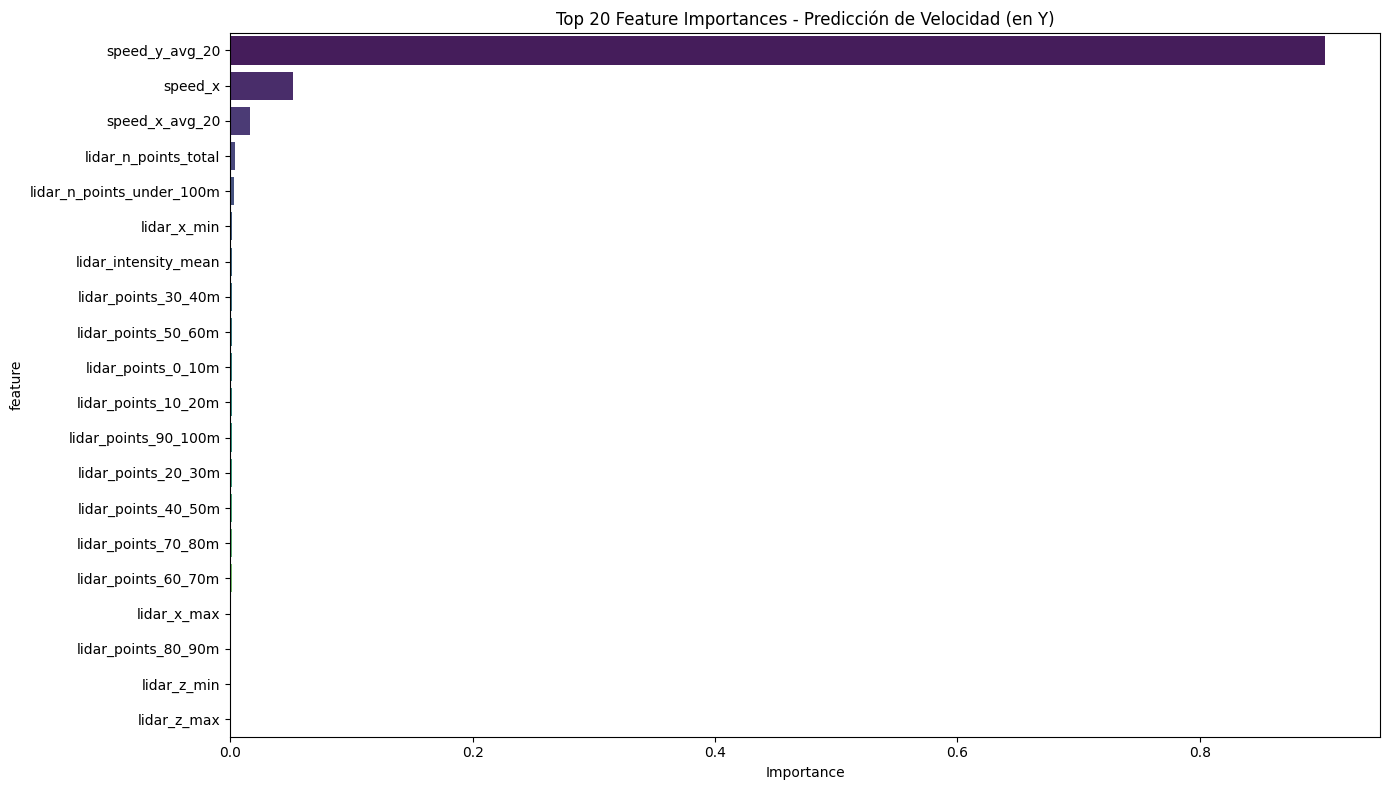


ANÁLISIS DE ERRORES:
Error máximo: 8.529 m/s
Error mediano: 0.507 m/s
% errores < 0.5 m/s: 49.6%
% errores < 1.0 m/s: 67.4%


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

# Usar TODAS las columnas numéricas excepto las problemáticas para leakage
exclude_cols = ['sequence_id', 'frame_id', 'timestamp', 'time_seconds', 'speed_y',
                'pose_x', 'pose_y', 'pose_z', 'pose_qx', 'pose_qy', 'pose_qz', 'pose_qw']
all_numeric_cols = df_moving.select_dtypes(include=[np.number]).columns.tolist()
# Filtrar columnas a usar
features = [col for col in all_numeric_cols if col not in exclude_cols]

print(f"Usando {len(features)} features:")
print(features)
target = 'speed_y'

# Separar secuencias
all_sequences = df_moving['sequence_id'].unique()
train_seq, temp_seq = train_test_split(all_sequences, test_size=0.3, random_state=42)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.33, random_state=42)
# Crear datasets
def get_data(sequences):
    mask = df_moving['sequence_id'].isin(sequences)
    X = df_moving.loc[mask, features].fillna(0)
    y = df_moving.loc[mask, target]
    return X, y

X_train, y_train = get_data(train_seq)
X_val, y_val = get_data(val_seq)
X_test, y_test = get_data(test_seq)
print(f"\nTamaños de los sets:")
print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# modelo y estandarizar que van a ir a BENTO
# Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X_train_scaled, y_train)

# Evaluar
print("\nRESULTADOS:")
for name, X, y in [('Train', X_train_scaled, y_train), ('Val', X_val_scaled, y_val), ('Test', X_test_scaled, y_test)]:
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"{name}:")
    print(f"  MAE = {mae:.3f}")
    print(f"  R²  = {r2:.3f}")
# Feature importance
importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
importance = importance.sort_values('importance', ascending=False)

print(f"\nTOP 15 FEATURES:")
print(importance.head(15).to_string(index=False))

# Visualizar
plt.figure(figsize=(14, 8))
top_20 = importance.head(20)
sns.barplot(x='importance', y='feature', data=top_20, palette='viridis')
plt.title('Top 20 Feature Importances - Predicción de Velocidad (en Y)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Análisis de errores
print("\nANÁLISIS DE ERRORES:")
y_test_pred = model.predict(X_test_scaled)
errors = np.abs(y_test - y_test_pred)

print(f"Error máximo: {errors.max():.3f} m/s")
print(f"Error mediano: {np.median(errors):.3f} m/s")
print(f"% errores < 0.5 m/s: {(errors < 0.5).mean()*100:.1f}%")
print(f"% errores < 1.0 m/s: {(errors < 1.0).mean()*100:.1f}%")

Hemos realizado una **selección de 7 características** para optimizar el modelo antes de desplegarlo en BentoML, ya que en el análisis anterior se puede apreciar que muchas de las variables originales no aportaban valor predictivo significativo. Utilizando la importancia de características de Random Forest, seleccionamos exclusivamente las 7 más relevantes: `speed_y_avg_20`, `speed_x_avg_20`, `speed_x`, `lidar_n_points_total`, `lidar_intensity_mean`, `lidar_n_points_under_100m` y `lidar_points_10_20m`. Esta reducción elimina ruido y redundancia, resultando en un **modelo más interpretable, eficiente y ligero**. Para BentoML guardamos por separado el modelo (`model.pkl`) y el scaler (`scaler.pkl`), asegurando que se utilicen únicamente estas 7 variables normalizadas, lo que simplifica la integración y acelera la inferencia.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)


# Selección secuencial de 7 variables
def select_top_features(df, target='speed_y', n_features=7, seed=42):
    # Columnas a excluir
    exclude_cols = ['sequence_id', 'frame_id', 'timestamp', 'time_seconds', target,
                    'pose_x', 'pose_y', 'pose_z', 'pose_qx', 'pose_qy', 'pose_qz', 'pose_qw']
    # Todas las columnas numéricas
    all_numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Variables candidatas
    candidate_features = [col for col in all_numeric_cols if col not in exclude_cols]
    # Entrenar modelo inicial con todas las variables
    X = df[candidate_features].fillna(0)
    y = df[target]
    
    # Estandarizar
    scaler_temp = StandardScaler()
    X_scaled = scaler_temp.fit_transform(X)    
    # Modelo para importancia
    model_temp = RandomForestRegressor(n_estimators=50, random_state=seed, n_jobs=-1)
    model_temp.fit(X_scaled, y)
    
    # Obtener importancia
    importance_df = pd.DataFrame({
        'feature': candidate_features,
        'importance': model_temp.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Seleccionar top n_features
    selected_features = importance_df.head(n_features)['feature'].tolist()
    print(f"Top {n_features} features seleccionadas:")
    for i, feat in enumerate(selected_features, 1):
        imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
        print(f"  {i:2d}. {feat} (importancia: {imp:.4f})")
    
    return selected_features, importance_df

# Cargar y preparar datos
# Suponiendo que tienes df_moving
df_moving = pd.read_csv("./data_augmented.csv")
# Seleccionar esas 7 mejores features
features, importance_df = select_top_features(df_moving, target='speed_y', n_features=7, seed=SEED)
target = 'speed_y'

# 3. Separación por secuencias
all_sequences = df_moving['sequence_id'].unique()
# Ordenar secuencias para reproducibilidad
all_sequences_sorted = sorted(all_sequences)
# Separar en train/val/test (70/20/10)
train_seq, temp_seq = train_test_split(all_sequences_sorted, test_size=0.3, random_state=SEED)
val_seq, test_seq = train_test_split(temp_seq, test_size=1/3, random_state=SEED)  # 30% * 1/3 = 10% test

print(f"Train: {len(train_seq)}")
print(f"Val:   {len(val_seq)}")
print(f"Test:  {len(test_seq)}")

# Crear datasets
def get_data(sequences):
    mask = df_moving['sequence_id'].isin(sequences)
    X = df_moving.loc[mask, features].fillna(0)
    y = df_moving.loc[mask, target]
    return X, y

X_train, y_train = get_data(train_seq)
X_val, y_val = get_data(val_seq)
X_test, y_test = get_data(test_seq)


# Estandarizar (guardar scaler)
print("\nENTRENANDO SCALER...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Entrenar modelo final
print("\nENTRENANDO RANDOM FOREST...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

# Evaluar
print("\nRESULTADOS DEL MODELO (7 features):")
print("-" * 50)

for name, X, y in [('TRAIN', X_train_scaled, y_train), 
                    ('VAL', X_val_scaled, y_val), 
                    ('TEST', X_test_scaled, y_test)]:
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    rmse = np.sqrt(np.mean((y - preds) ** 2))
    
    print(f"\n{name}:")
    print(f"  MAE  = {mae:.3f} m/s ({mae*3.6:.1f} km/h)")
    print(f"  RMSE = {rmse:.3f} m/s")
    print(f"  R²   = {r2:.3f}")
    print(f"  Real: prom={y.mean():.3f} ± {y.std():.3f} m/s")

# Feature importance del modelo final
print(f"\nIMPORTANCIA DE FEATURES FINAL:")
final_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(final_importance.to_string(index=False))

# Visualización
print("\nVISUALIZACIONES")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Importancia de features
axes[0,0].barh(final_importance['feature'][::-1], final_importance['importance'][::-1])
axes[0,0].set_xlabel('Importancia')
axes[0,0].set_title('Top 7 Features - Random Forest')
axes[0,0].grid(True, alpha=0.3, axis='x')

# Predicciones vs Reales (Test)
y_test_pred = model.predict(X_test_scaled)
axes[0,1].scatter(y_test, y_test_pred, alpha=0.5, s=10)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,1].set_xlabel('Real (m/s)')
axes[0,1].set_ylabel('Predicho (m/s)')
axes[0,1].set_title(f'Test Set - R²={r2_score(y_test, y_test_pred):.3f}')
axes[0,1].grid(True, alpha=0.3)

# Distribución de errores
errors = np.abs(y_test - y_test_pred)
axes[1,0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1,0].axvline(errors.mean(), color='red', linestyle='--', 
                  label=f'Promedio: {errors.mean():.3f} m/s')
axes[1,0].set_xlabel('Error absoluto (m/s)')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de errores (Test)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Comparación train/test performance
metrics_df = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'MAE': [mean_absolute_error(y_train, model.predict(X_train_scaled)),
            mean_absolute_error(y_test, y_test_pred)],
    'R²': [r2_score(y_train, model.predict(X_train_scaled)),
           r2_score(y_test, y_test_pred)]
})

x = np.arange(len(metrics_df))
width = 0.35
axes[1,1].bar(x - width/2, metrics_df['MAE'], width, label='MAE (m/s)', color='skyblue')
axes[1,1].bar(x + width/2, metrics_df['R²'], width, label='R²', color='lightgreen')
axes[1,1].set_xlabel('Conjunto de datos')
axes[1,1].set_ylabel('Métrica')
axes[1,1].set_title('Comparación Train vs Test')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(metrics_df['Set'])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Modelo ONCE - 7 Features (Seed={SEED})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("RESUMEN FINAL:")
print("="*60)
print(f"Modelo: Random Forest con 7 features")
print(f"Seed: {SEED} (totalmente reproducible)")
print(f"Features: {', '.join(features)}")
print(f"Performance Test: MAE={mean_absolute_error(y_test, y_test_pred):.3f} m/s, R²={r2_score(y_test, y_test_pred):.3f}")
print("="*60)


# Guardar para BENTO
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Guardar scaler solo  
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

FileNotFoundError: [Errno 2] No such file or directory: './data_augmented.csv'

In [ ]:
# Guardar estos dataset para usar el modelo desde Streamlit con BENTOML
X_test.to_csv("./PROJECT/Industrial/processing/test_bent.csv", index=False)
y_test.to_csv("./PROJECT/Industrial/processing/test_bent_y.csv", index=False)